<h1 align="center">Problem 2 - Practical HBM</h1>
<h2 align="center">One- and Two-Component Gaussian Mixture Hierarchcial Bayesian Modeling with PyJAGS</h2>
<h3 align="center">Simulating the eccentricity distribution of hot Jupiter exoplanets from the Kepler Mission</h3> 
<h4 align="center">LSSTC DSFP Session 4, September 21st, 2017</h4>
<h5 align="center">Author: Megan I. Shabram, PhD, 
NASA Postdoctoral Program Fellow,  mshabram@gmail.com</h5>


1. Use the code below to explore a two-component Gaussian mixture model
2. Using the simulated data code cells below, evaluate the one-component truncated Gaussian generative model simualted data with the two-component Gaussian mixture HBM. What do you notice about the posteriors for the mixture fractions? 
3. Repeat this exersize but now evaluating simulated data from a one-component generative model with a two-component HBM. 
4. Notebook 3: Using the JAGS model code block for a break-point HBM, set up and evaluate the break-point HBM on the real Kepler eclipsing binary data set provided (some code is provided for analysis).  



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyjags
import pickle

from __future__ import division, print_function
from pandas.tools.plotting import *
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
#plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%qtconsole


<h3 align="left"> 1. Generate simulated data set: one- and two-component truncated Gaussian mixture generative models:</h3>


In [3]:
## function to draw from truncated normal, this function will be used for both the 
## one- and two-componenet cases in this workbook.  

def rnorm_bound( Ndata, mu, prec, lower_bound = 0.0, upper_bound = float('Inf')):
    x = np.zeros(Ndata)
    #print(x)
    for i in range(0, Ndata): 
            #print(i)
            while True:
                x[i] = np.random.normal(mu,prec,1)
                if( (x[i]>lower_bound) and (x[i]<upper_bound) ): 
                    break
    return x;

In [4]:
## Check the output to make sure the function is outputting as expected. 
#print(np.random.normal(0,0.0001,10))
print(rnorm_bound(10, 0.0, 0.001, lower_bound=-1,upper_bound=1))

[  3.88181353e-04   1.70206665e-03  -6.49619174e-04  -4.28755904e-05
   4.00055394e-05   9.18209256e-04   1.89805553e-03   1.57545200e-03
   4.07282279e-04   4.58256983e-04]


[-0.13737272 -0.07162454  0.34212712  0.27651807  0.10644583  0.08456573
 -0.57208533  0.07595995  0.18377919  0.54454506  0.3590394  -0.15439031
 -0.47929261 -0.10274325 -0.20769449 -0.03427946 -0.20815516 -0.42199388
  0.24043123  0.19834015 -0.02580736  0.65336715 -0.03361495 -0.28369701
  0.08045459] [-0.16410076 -0.12238372  0.35488115  0.31925266  0.0707991   0.03545279
 -0.61346858  0.15744099  0.17078392  0.53251427  0.339625   -0.08903803
 -0.54259038 -0.13978033 -0.1099126   0.00306002 -0.28536514 -0.3757731
  0.2593411   0.21326309 -0.02123662  0.60212661 -0.01393157 -0.30314803
  0.08174582] [-0.0325885   0.16640343 -0.19446894  0.17973893  0.07123231 -0.11412355
 -0.18333375 -0.47940931 -0.44102565 -0.2713681  -0.14550616 -0.14441897
  0.271263    0.24822851  0.0783119  -0.0489408   0.61774566 -0.16520354
  0.12307896  0.16306661 -0.18595262  0.49803995 -0.18341738  0.17784902
 -0.45908374] [-0.22352981  0.22531853 -0.24503409  0.17855162  0.02328221 -0.1726
  0.02396939 -

(array([ 2.,  1.,  2.,  2.,  5.,  4.,  3.,  4.,  0.,  2.]),
 array([-0.61346858, -0.49190906, -0.37034954, -0.24879002, -0.12723051,
        -0.00567099,  0.11588853,  0.23744805,  0.35900757,  0.48056709,
         0.60212661]),
 <a list of 10 Patch objects>)

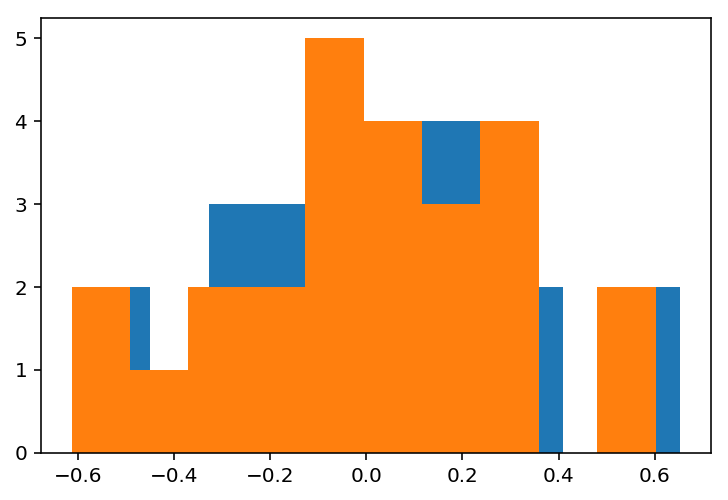

In [5]:
## One-component Gaussian Mixture Simulated Data for both projected eccentricity terms
## Below we designate the population values of our generative model. These are the 
## truths that we should recover if our hiararchical Bayesian model is properly specified 
## and diagnostics have indicated that the simulation has "not not converged". "You can't 
## prove convergence, at best you can fail to prove a failure to converge".

## In this simulated data set, their are 25 planetary systems (with one planet each)
Ndata = 25 
## Here we asign the dispersion of the simulated population to be 0.3, this is 
## the truth we wish to recovern 
sigmae = 0.3 
## We approximate the uncertainty for each measurement as normally distributed about a 
## reporte measurement point estimate.  
## For the eccentricity distribution for Hot Jupiters, the physical models used to derive 
## these produce larger uncertainty in k by a factor of 2. 
sigmahobs = 0.04
sigmakobs = 0.08

h = np.repeat(0.,Ndata)
k = np.repeat(0.,Ndata)
hhat = np.repeat(0.,Ndata)
khat = np.repeat(0.,Ndata)
hhat_sigma  = np.repeat(sigmahobs,Ndata)
khat_sigma  = np.repeat(sigmakobs,Ndata)

#print(khat_sigma)


for i in range(0,Ndata):
    h[i] = rnorm_bound(1,0,sigmae,lower_bound=-1,upper_bound=1)
    lb = -np.sqrt(1-h[i]**2)
    ub = np.sqrt(1-h[i]**2)
    k[i] = rnorm_bound(1,0,sigmae,lower_bound=lb,upper_bound=ub) 
    hhat[i] = rnorm_bound(1,h[i],sigmahobs,lower_bound=-1,upper_bound=1)
    khat[i] = rnorm_bound(1,k[i],sigmakobs,lower_bound=lb,upper_bound=ub)

## Vizualize the true data values, and the simulated measurements:     
print(h, hhat, k, khat)
plt.hist(h)
plt.hist(hhat)

In [7]:
## JAGS user manual: 
## http://www.uvm.edu/~bbeckage/Teaching/DataAnalysis/Manuals/manual.jags.pdf

## JAGS model code

## model code is the one-component truncated gaussian mixture HBM code from previous 
## notebook


code1 = '''

model {
        
    #Population parameters
    e_sigma ~ dunif(0.0, 1.0)
    e_phi <- 1/(e_sigma*e_sigma)
        
    for (n in 1:Ndata){
    
        #True planet properties
        h[n] ~ dnorm(0, e_phi) T(-1,1) #Can try multivariate truncated normal in future
        k[n] ~ dnorm(0, e_phi) T(-sqrt(1-h[n]*h[n]),sqrt(1-h[n]*h[n]))
            
        #Observed planet properties
        hhat[n] ~ dnorm(h[n], 1.0/(hhat_sigma[n]*hhat_sigma[n])) T(-1,1)
        khat[n] ~ dnorm(k[n], 1.0/(khat_sigma[n]*khat_sigma[n])) T(-sqrt(1-hhat[n]*hhat[n]),sqrt(1-hhat[n]*hhat[n]))
    }
        
}
'''

In [8]:
## Load additional JAGS module
pyjags.load_module('glm')
pyjags.load_module('dic')


## See blog post for origination of the adapted analysis tools used here and below:
## https://martynplummer.wordpress.com/2016/01/11/pyjags/

num_chains = 4
iterations = 10000


## data list include only variables in the model
model = pyjags.Model(code1, data=dict( Ndata=Ndata, hhat=hhat, khat=khat, 
                                     hhat_sigma=hhat_sigma, khat_sigma=khat_sigma), 
                     chains=num_chains, adapt=1000)

## Code to speed up compute time. This feature might not be 
## well tested in pyjags at this time. 
## threads=4, chains_per_thread=1 

## 500 warmup / burn-in iterations, not used for inference.
model.sample(500, vars=[])

## Run model for desired steps, monitoring hyperparameter variables, and latent variables
## for hierarchical Bayesian model.
## Returns a dictionary with numpy array for each monitored variable.
## Shapes of returned arrays are (... shape of variable ..., iterations, chains).
## samples = model.sample(#iterations per chain here, vars=['e_sigma', 'h', 'k'])
samples = model.sample(iterations, vars=['e_sigma', 'h', 'k'])

## Code to save, open and use pickled dictionary of samples:
## -- Pickle the data --
#with open('ecc_1_test.pkl', 'wb') as handle:
#   pickle.dump(samples, handle)
## -- Retrieve pickled data --
#with open('ecc_1_test.pkl', 'rb') as handle:
#   retrieved_results = pickle.load(handle)


adapting: iterations 4000 of 4000, elapsed 0:00:03, remaining 0:00:00
sampling: iterations 2000 of 2000, elapsed 0:00:02, remaining 0:00:00
sampling: iterations 12916 of 40000, elapsed 0:00:10, remaining 0:00:20
sampling: iterations 19608 of 40000, elapsed 0:00:15, remaining 0:00:15
sampling: iterations 26196 of 40000, elapsed 0:00:20, remaining 0:00:11
sampling: iterations 39200 of 40000, elapsed 0:00:30, remaining 0:00:01
sampling: iterations 40000 of 40000, elapsed 0:00:30, remaining 0:00:00


In [9]:
## Generalize code for both h and k below. 

#print(samples)
#print(samples.items())

## Print and check the shape of the resultant samples dictionary:
print(samples['e_sigma'].shape)
print(samples['e_sigma'].squeeze(0).shape)
print(samples['h'].shape)
print(samples['k'][0,:,:].shape)
print('-----')


## Update the samples dictionary so that it includes keys for the latent variables
## Also, we will use LaTeX formatting to help make legible plots ahead.  
samples_Nm1 = {}

## adjust the thin varible to only look at every 10th population element by setting it to 10
thin = 1
## Need to enter the number of hyperparameter variables here:
numHyperParams = 1
## Specify the dimension we want for our plot below, for legibility.  
dim = (Ndata/thin)*2 + numHyperParams
print(dim)

for i in np.arange(0,Ndata,thin):
    #hval = 'h'+str(i+1)
    #kval = 'k'+str(i+1)
    #print(hval)
    #print(kval)
    #samples_Nm1({hval: samples['h'][i,:,:]})
    samples_Nm1.update({'$h_{'+str(i+1)+'}$': samples['h'][i,:,:], '$k_{'+str(i+1)+'}$': samples['k'][i,:,:]})
#print(samples_2['h11'].shape)

## Add the hyperparameter marginal posterior back in:
samples_Nm1.update({'$e_{\sigma}$': samples['e_sigma'].squeeze(0)})

## Below, examine the updated and reformatted sample dictionary to include keys for 
## latent variables 
for j, i in samples_Nm1.items():
    print(j)
    print(i)
samples_Nm1['$h_{5}$'][0]

(1, 10000, 4)
(10000, 4)
(25, 10000, 4)
(10000, 4)
-----
51.0
$h_{2}$
[[-0.06336514 -0.0929181  -0.15538577 -0.10547797]
 [-0.06398636 -0.05637359 -0.1050457  -0.14640935]
 [-0.06118934 -0.08123431 -0.13631472 -0.13967782]
 ..., 
 [-0.1100462  -0.01695256 -0.10856997 -0.09940516]
 [-0.10667518 -0.19860609 -0.09735881 -0.1593491 ]
 [-0.09910093 -0.13265174 -0.07145466 -0.18721257]]
$k_{6}$
[[-0.20461156 -0.17143435 -0.02443644 -0.17139893]
 [-0.17650749 -0.15887967 -0.06302504 -0.07799665]
 [-0.00942697 -0.17407119 -0.20867739 -0.12787305]
 ..., 
 [-0.19765048 -0.13195127 -0.10800108 -0.27553549]
 [-0.13539915 -0.08721253 -0.25648957 -0.3114243 ]
 [-0.16974694 -0.14488201 -0.27670496 -0.3020498 ]]
$k_{17}$
[[ 0.55181678  0.6478436   0.44103261  0.40304175]
 [ 0.6082647   0.72132462  0.4448584   0.50186986]
 [ 0.54401498  0.436542    0.35728491  0.46023474]
 ..., 
 [ 0.74648681  0.52594359  0.49896992  0.52610994]
 [ 0.55588416  0.54306754  0.594199    0.46531157]
 [ 0.51805347  0.528343

array([ 0.0909464 ,  0.07072115,  0.0524066 ,  0.03449539])

<div>  <p>Below is code to look at <b>summary statistics</b> of <b>the marginal posterior distributions</b>  (the probabilistic parameter estimates) 
for the hyperparameter and the latent variables 
(each population constituent), in this case <i>h</i> and <i>k</i> (a.k.a projected eccentricity here), of the exoplanet systems we are simulating). </p> </div>

In [10]:
## equal tailed 95% credible intervals, and posterior distribution means:
def summary(samples, varname, p=95):
    values = samples[varname][0]
    ci = np.percentile(values, [100-p, p])
    print('{:<6} mean = {:>5.1f}, {}% credible interval [{:>4.1f} {:>4.1f}]'.format(
      varname, np.mean(values), p, *ci))

for varname in samples_Nm1:
    summary(samples_Nm1, varname)


$h_{2}$ mean =  -0.1, 95% credible interval [-0.1 -0.1]
$k_{6}$ mean =  -0.1, 95% credible interval [-0.2 -0.0]
$k_{17}$ mean =   0.5, 95% credible interval [ 0.4  0.6]
$h_{3}$ mean =   0.3, 95% credible interval [ 0.3  0.4]
$h_{14}$ mean =  -0.1, 95% credible interval [-0.2 -0.1]
$k_{16}$ mean =   0.0, 95% credible interval [-0.0  0.1]
$k_{14}$ mean =   0.2, 95% credible interval [ 0.2  0.3]
$h_{15}$ mean =  -0.1, 95% credible interval [-0.2 -0.1]
$h_{17}$ mean =  -0.3, 95% credible interval [-0.3 -0.2]
$h_{5}$ mean =   0.1, 95% credible interval [ 0.0  0.1]
$k_{24}$ mean =   0.1, 95% credible interval [ 0.0  0.1]
$h_{18}$ mean =  -0.4, 95% credible interval [-0.5 -0.3]
$h_{19}$ mean =   0.3, 95% credible interval [ 0.3  0.3]
$k_{11}$ mean =  -0.0, 95% credible interval [-0.1  0.1]
$e_{\sigma}$ mean =   0.3, 95% credible interval [ 0.3  0.3]
$k_{22}$ mean =   0.4, 95% credible interval [ 0.3  0.5]
$k_{7}$ mean =   0.1, 95% credible interval [ 0.0  0.2]
$k_{9}$ mean =  -0.4, 95% credib

Variable
$e_{\sigma}$    0.289996
$h_{10}$        0.521918
$h_{11}$        0.333232
$h_{12}$       -0.087267
$h_{13}$       -0.532175
$h_{14}$       -0.136995
$h_{15}$       -0.108127
$h_{16}$        0.003457
$h_{17}$       -0.279843
$h_{18}$       -0.368736
$h_{19}$        0.254361
$h_{1}$        -0.160822
$h_{20}$        0.209441
$h_{21}$       -0.020524
$h_{22}$        0.590484
$h_{23}$       -0.013970
$h_{24}$       -0.297139
$h_{25}$        0.080214
$h_{2}$        -0.120063
$h_{3}$         0.347928
$h_{4}$         0.313068
$h_{5}$         0.069692
$h_{6}$         0.034677
$h_{7}$        -0.601025
$h_{8}$         0.154193
$h_{9}$         0.167527
$k_{10}$       -0.226859
$k_{11}$       -0.079397
$k_{12}$       -0.200681
$k_{13}$        0.241470
$k_{14}$        0.294506
$k_{15}$        0.106470
$k_{16}$        0.037600
$k_{17}$        0.529597
$k_{18}$       -0.081837
$k_{19}$        0.191103
$k_{1}$        -0.207181
$k_{20}$        0.317551
$k_{21}$       -0.142379
$k_{22}$        

/home/tunde/miniconda3/envs/dsfp_py27/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.


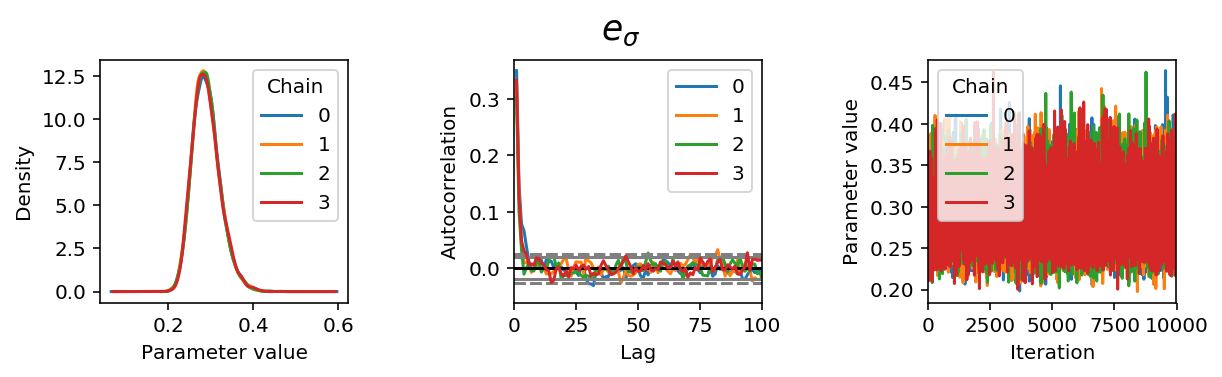

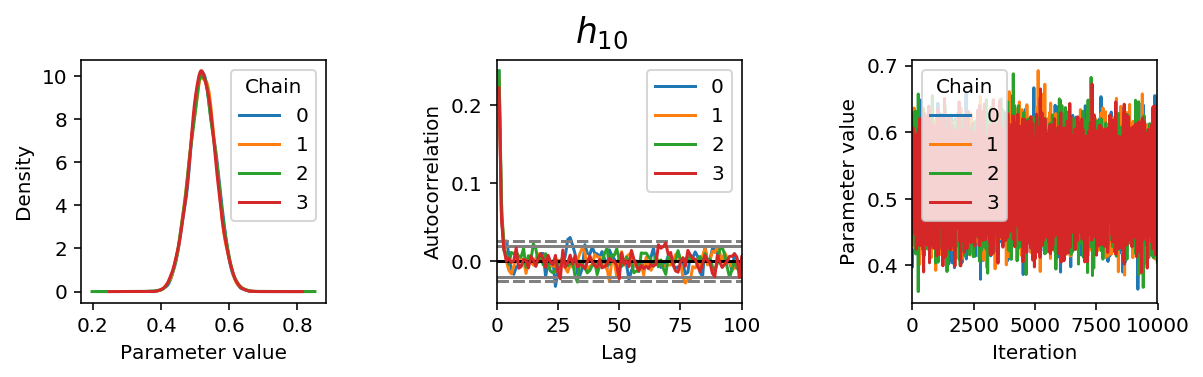

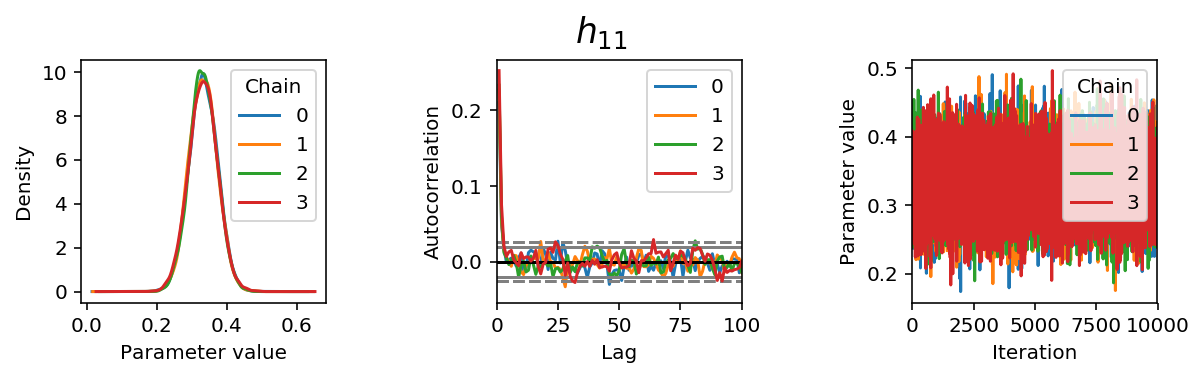

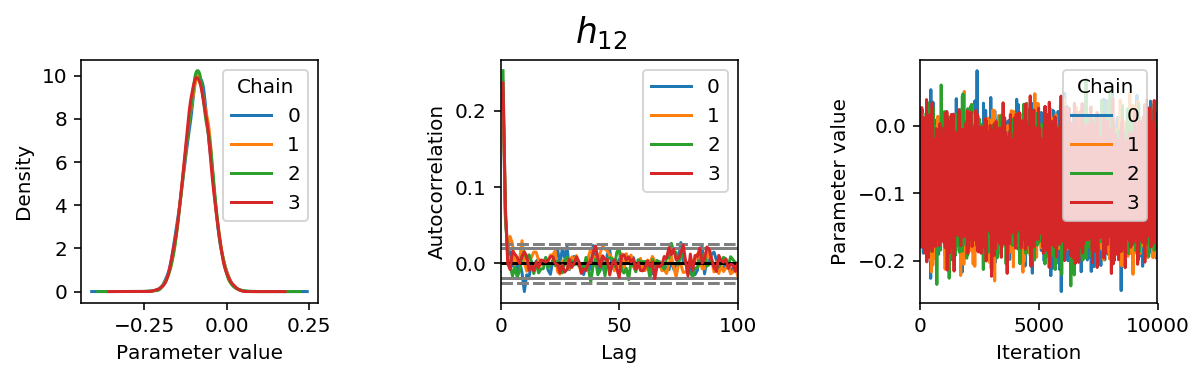

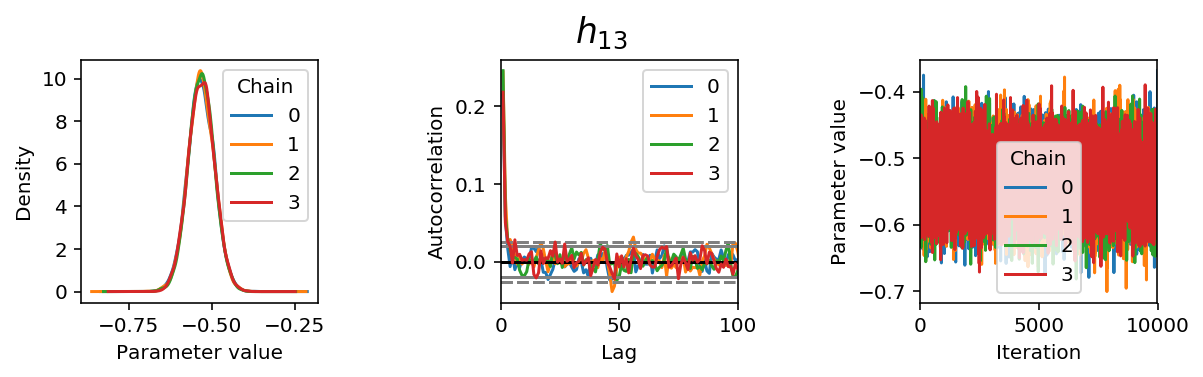

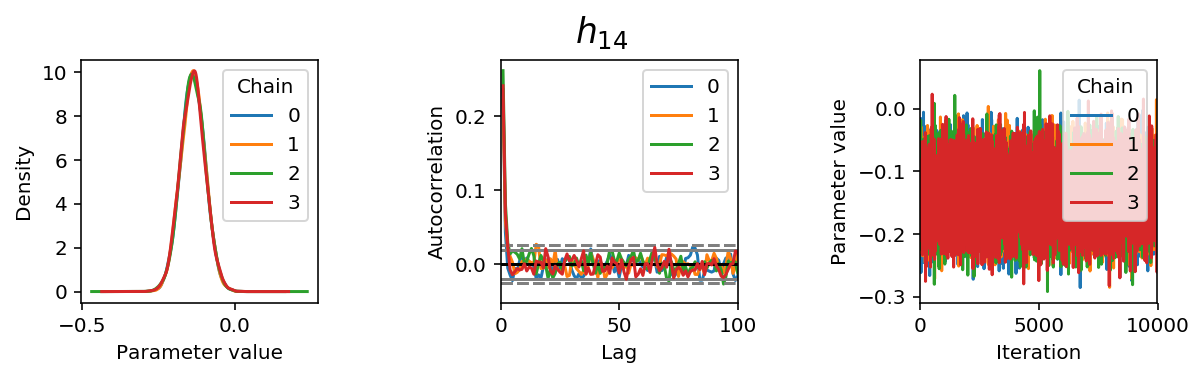

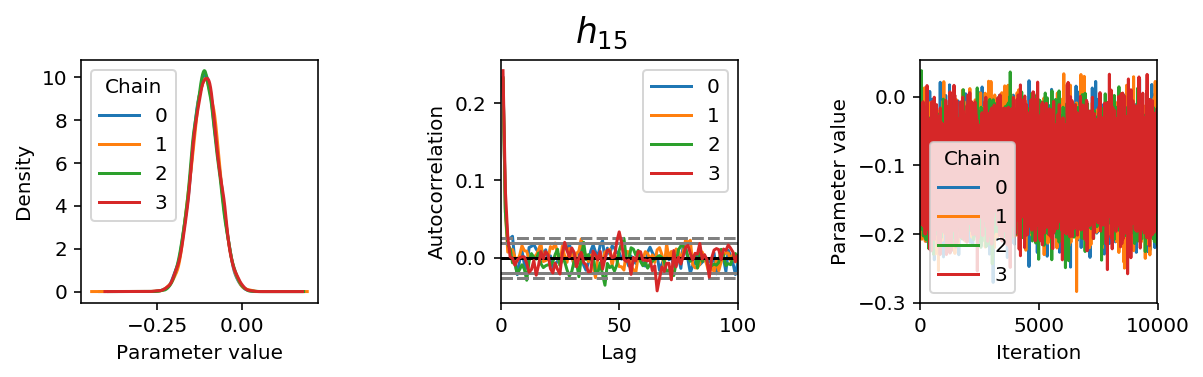

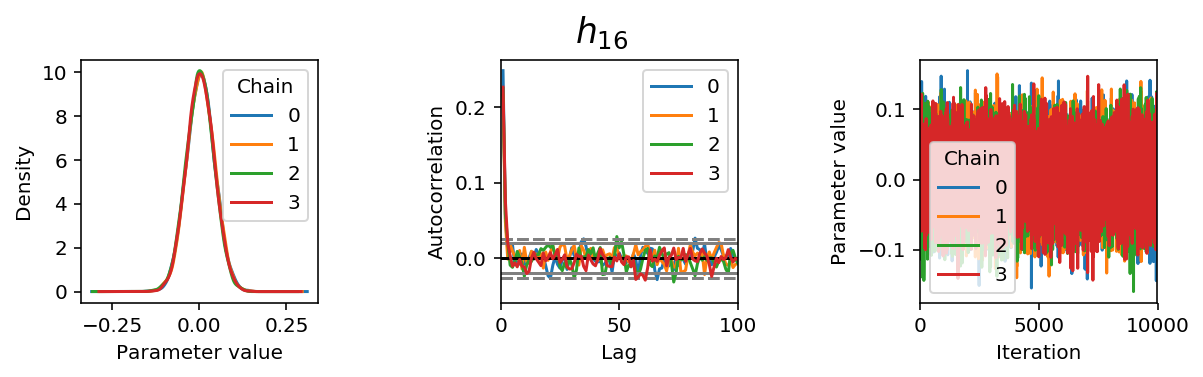

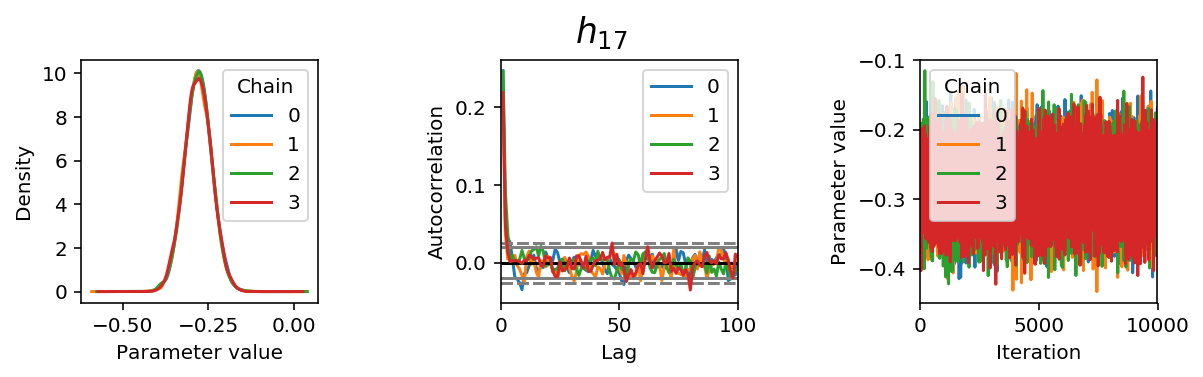

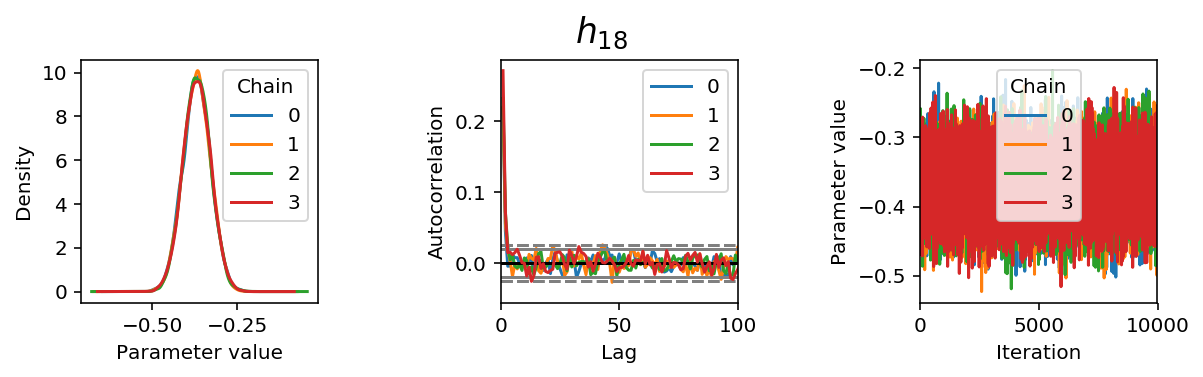

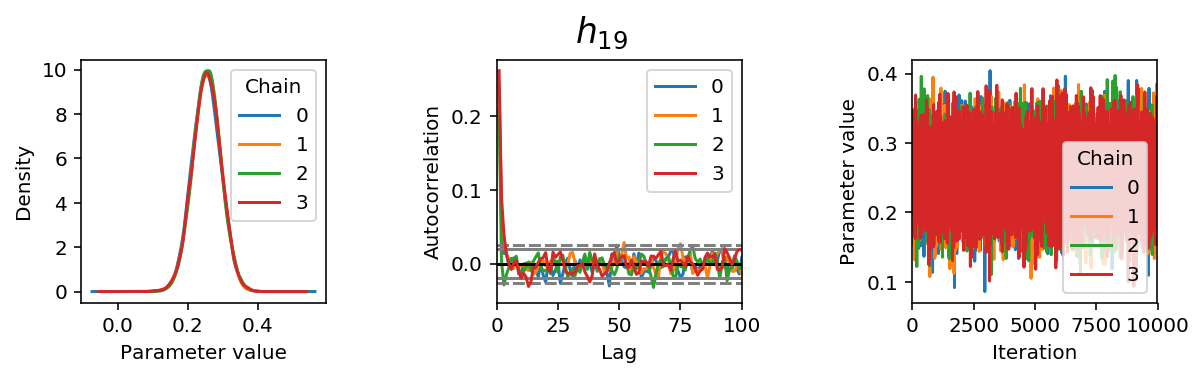

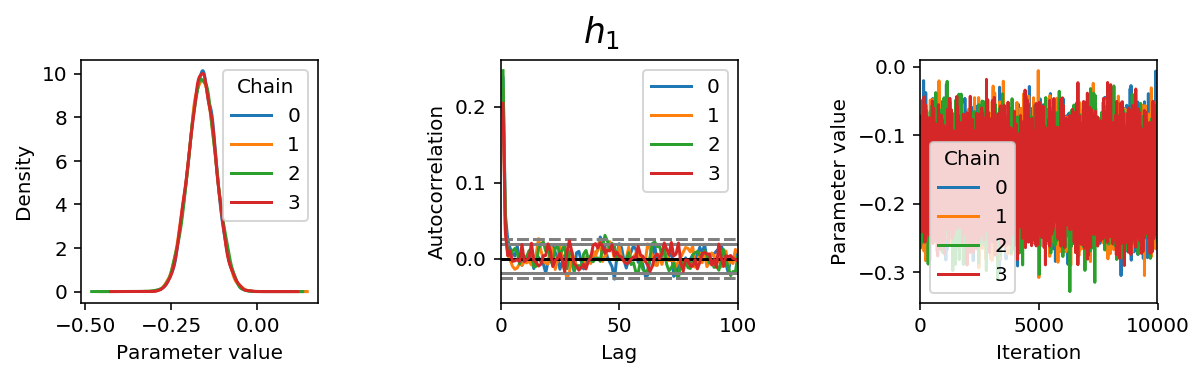

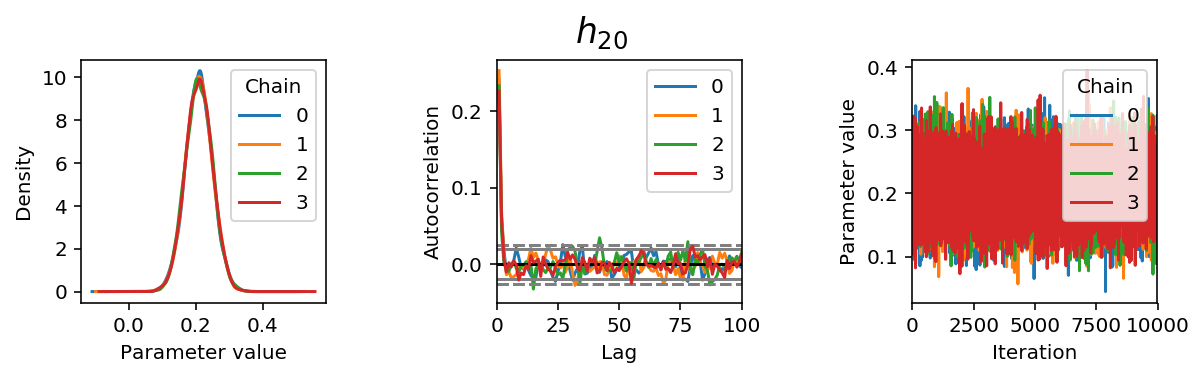

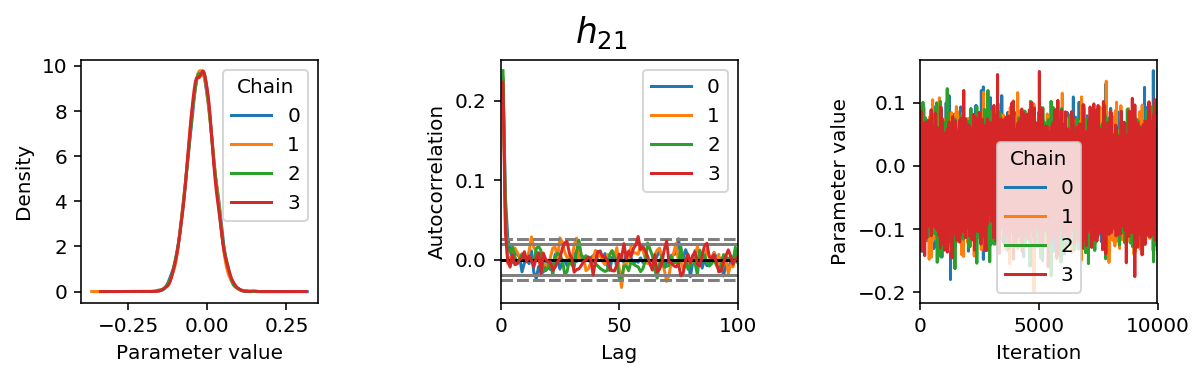

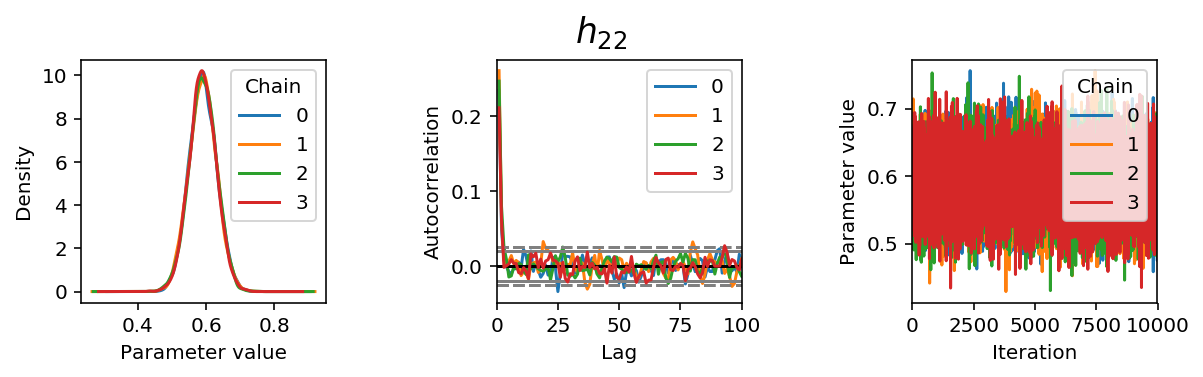

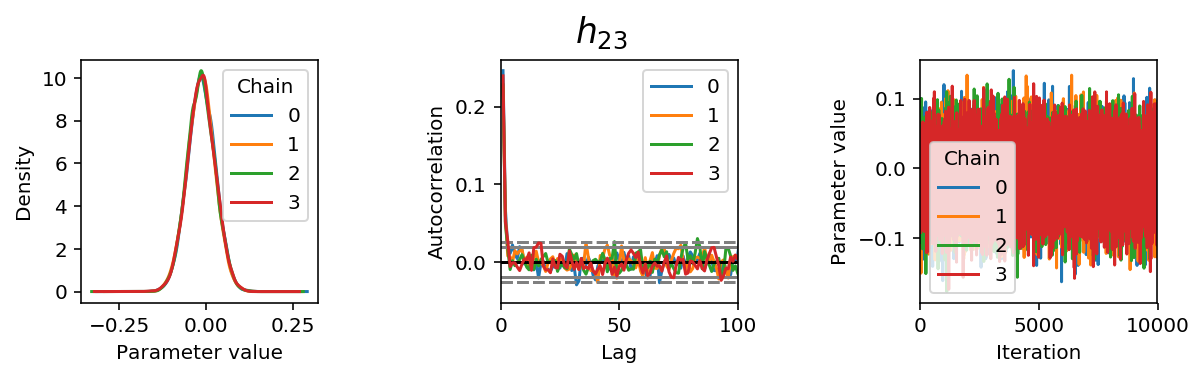

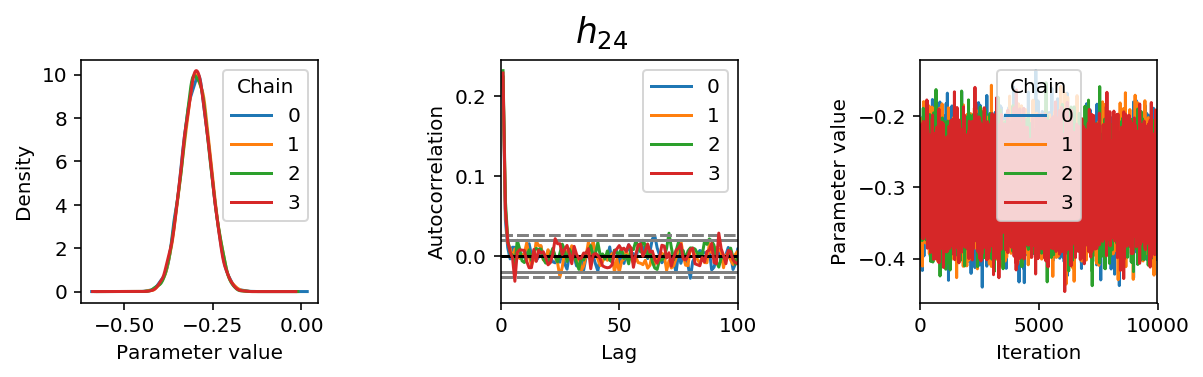

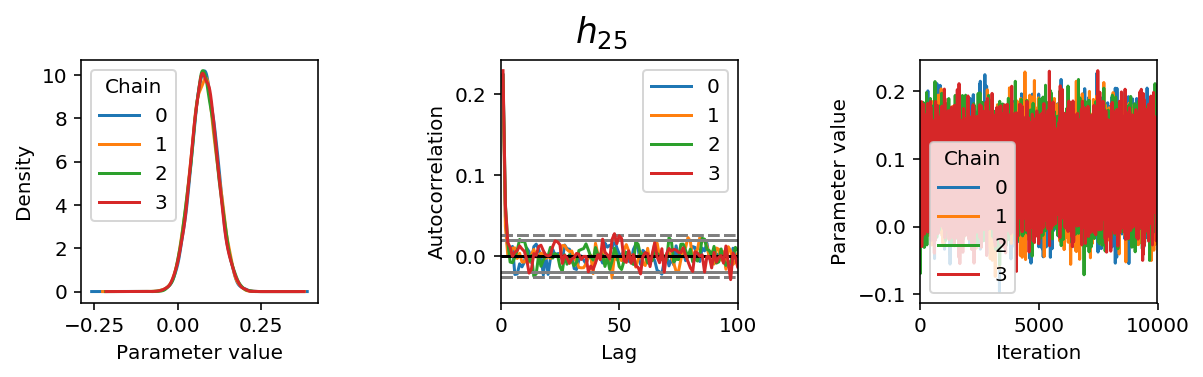

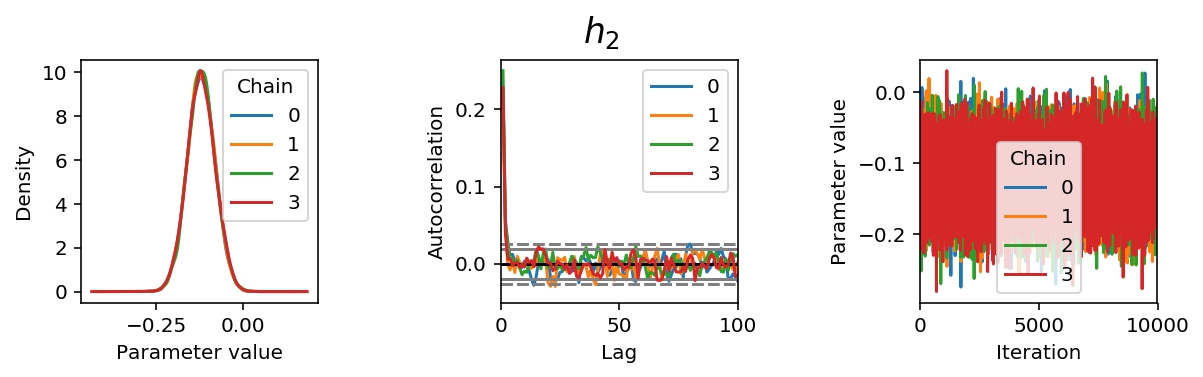

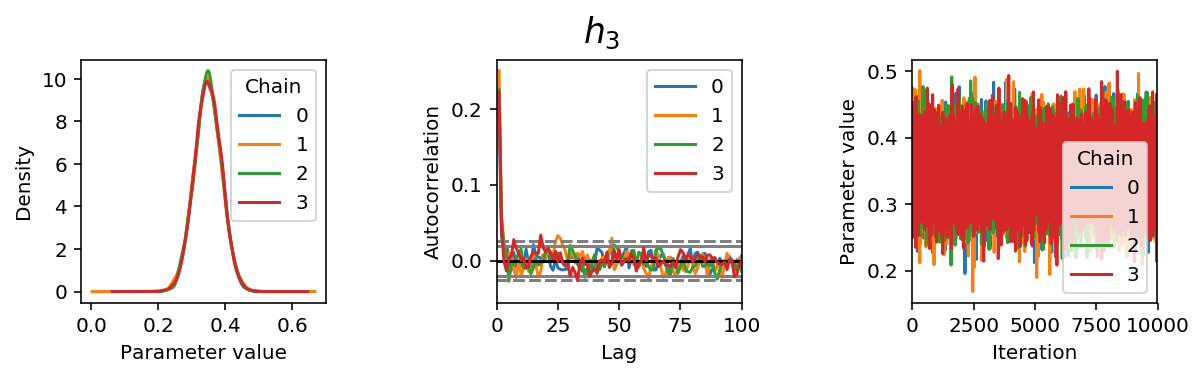

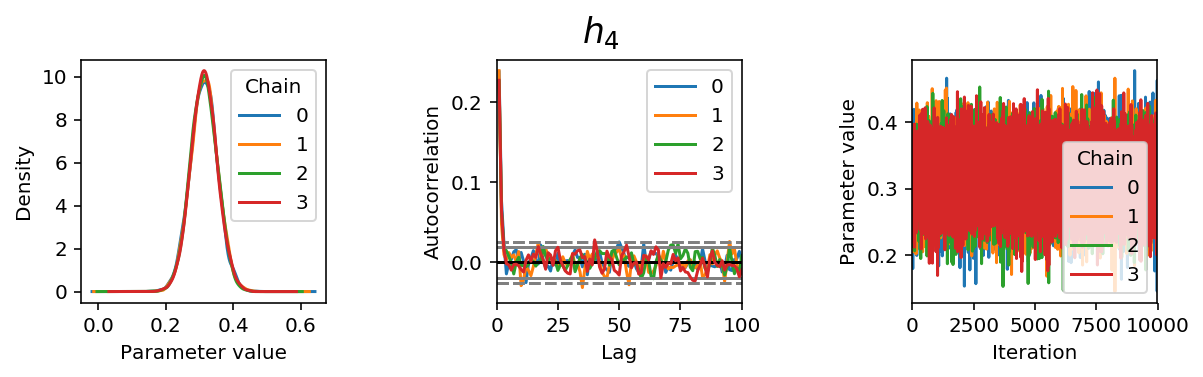

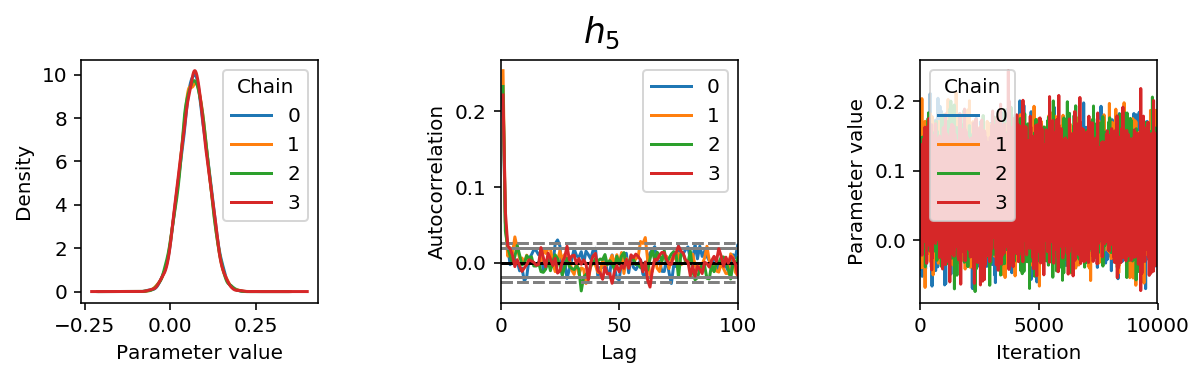

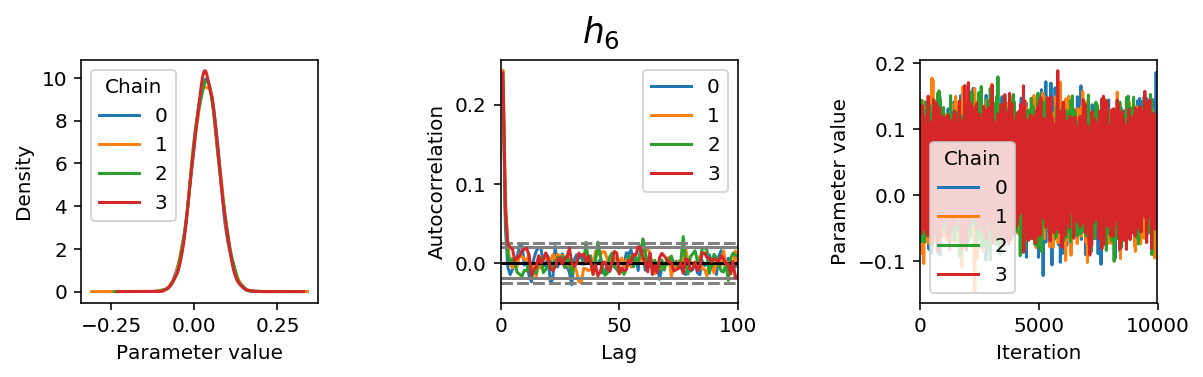

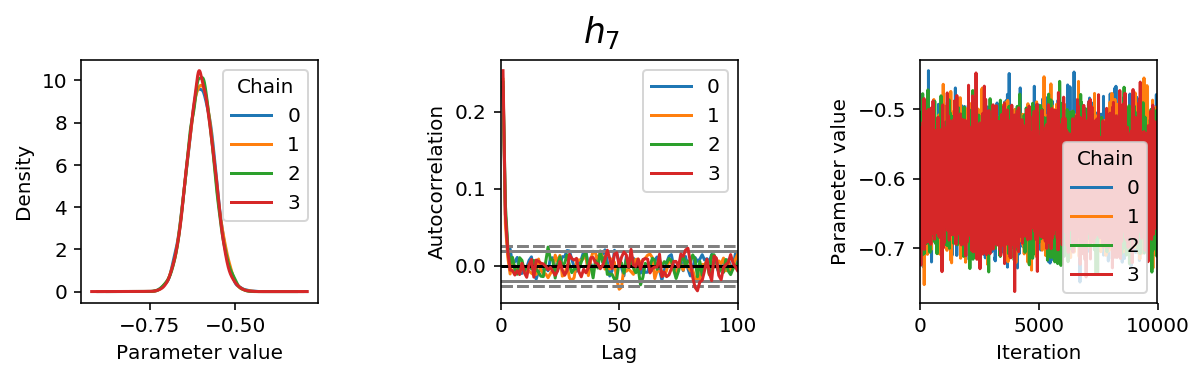

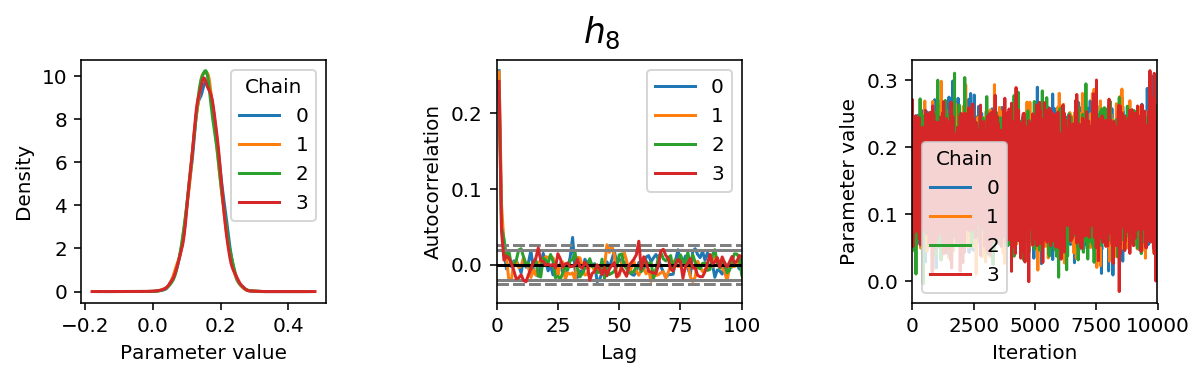

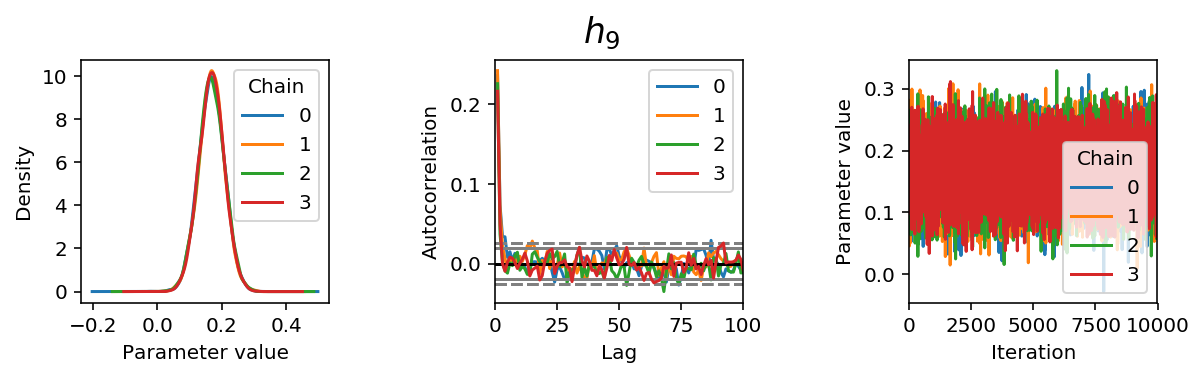

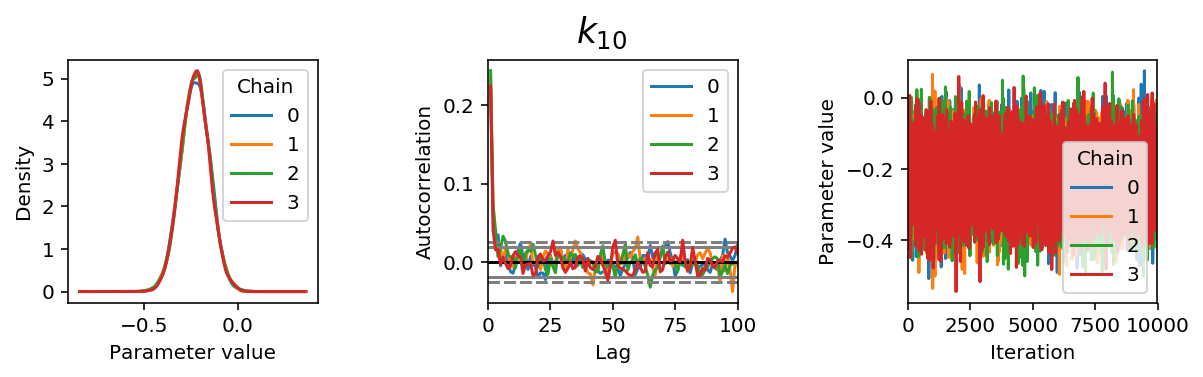

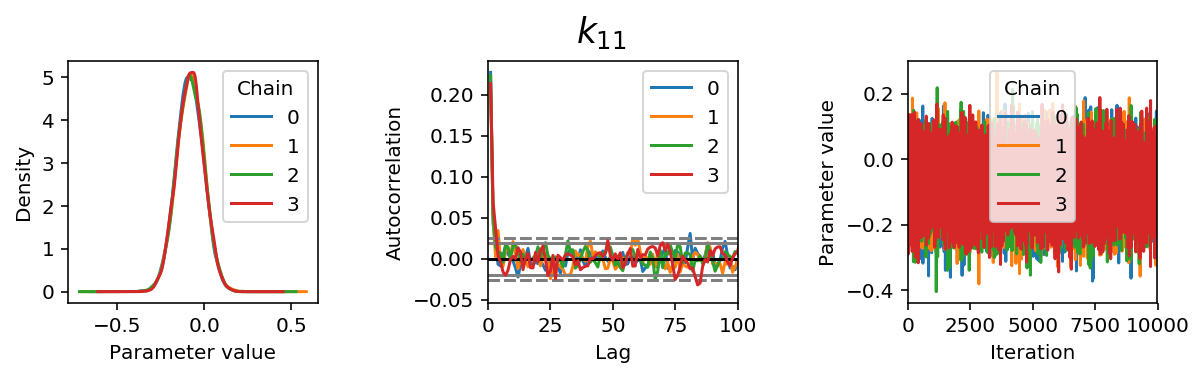

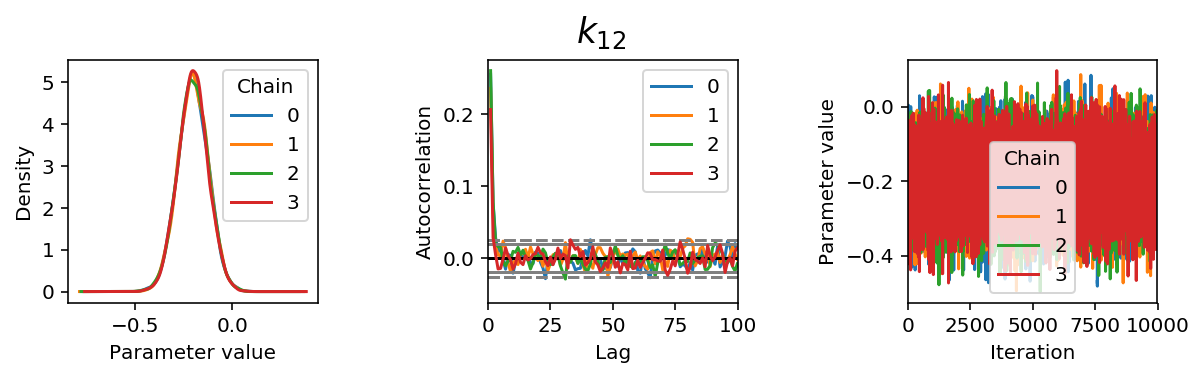

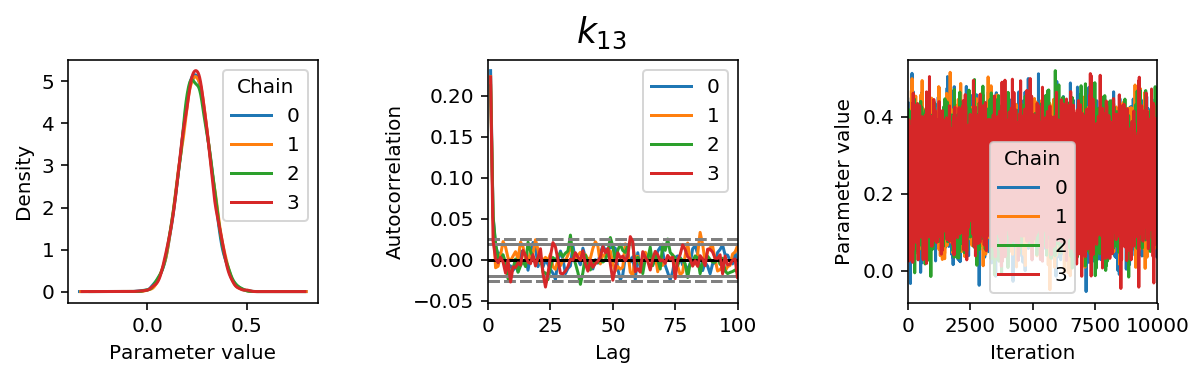

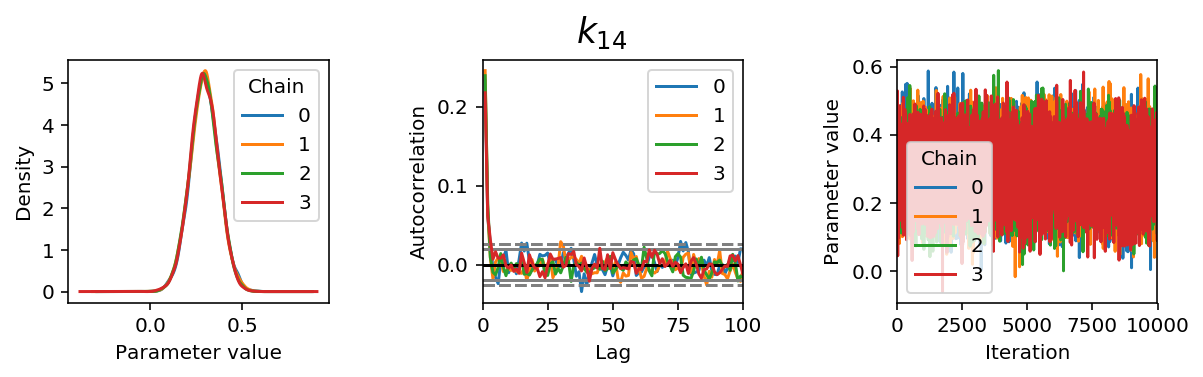

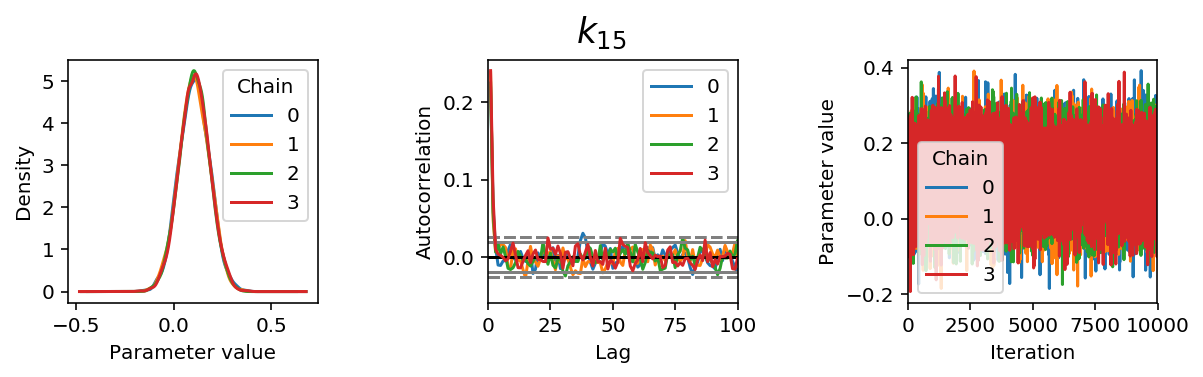

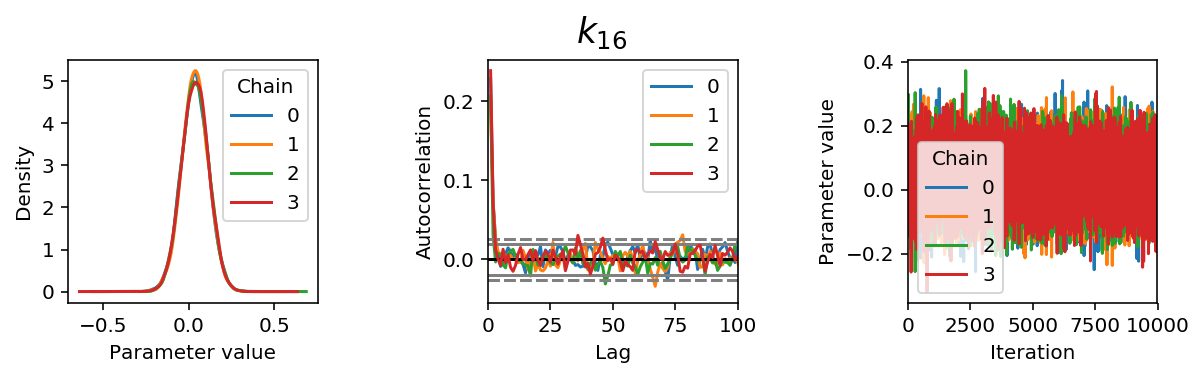

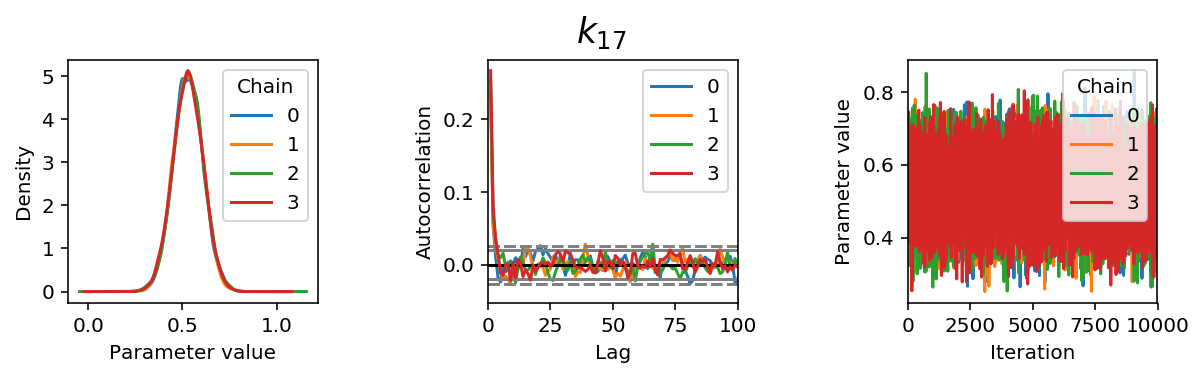

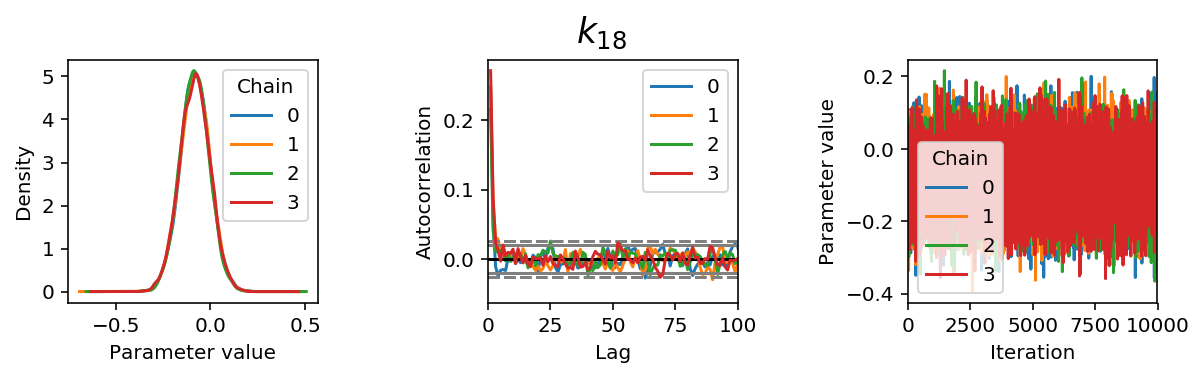

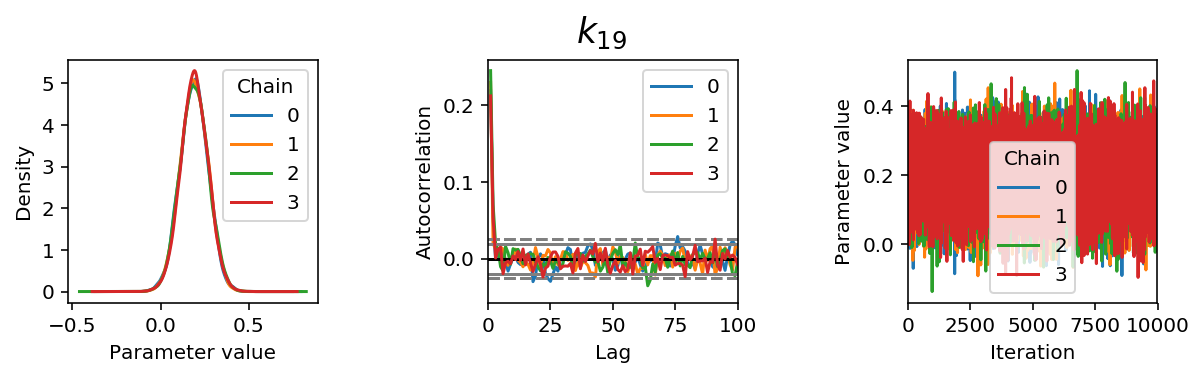

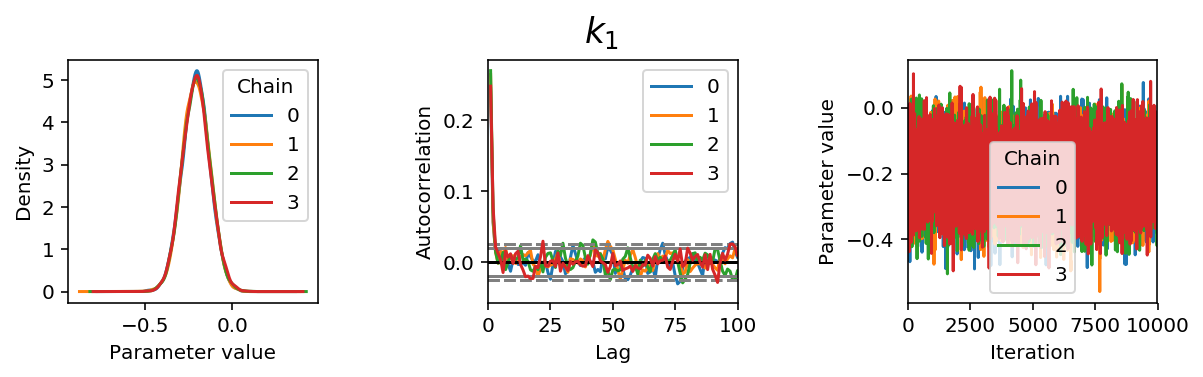

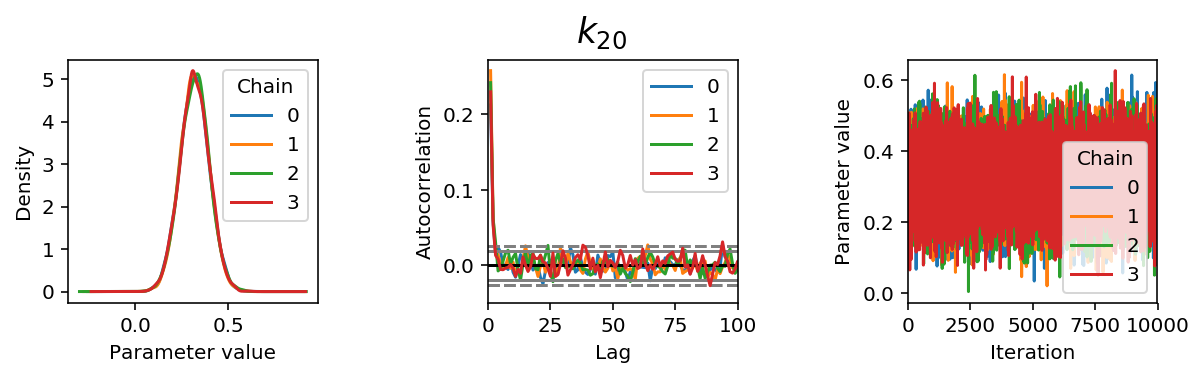

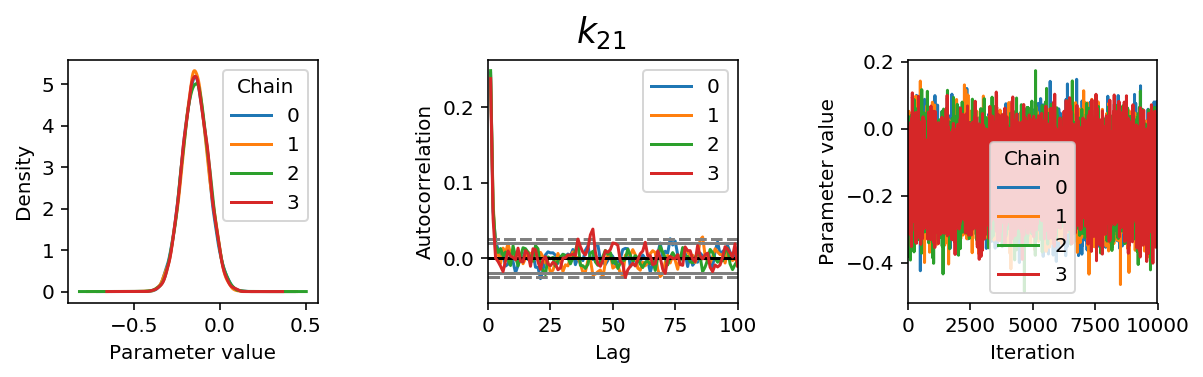

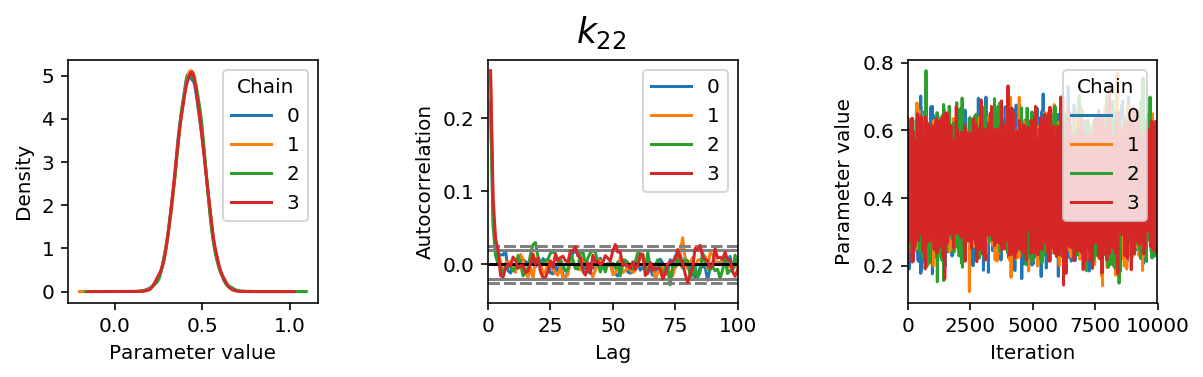

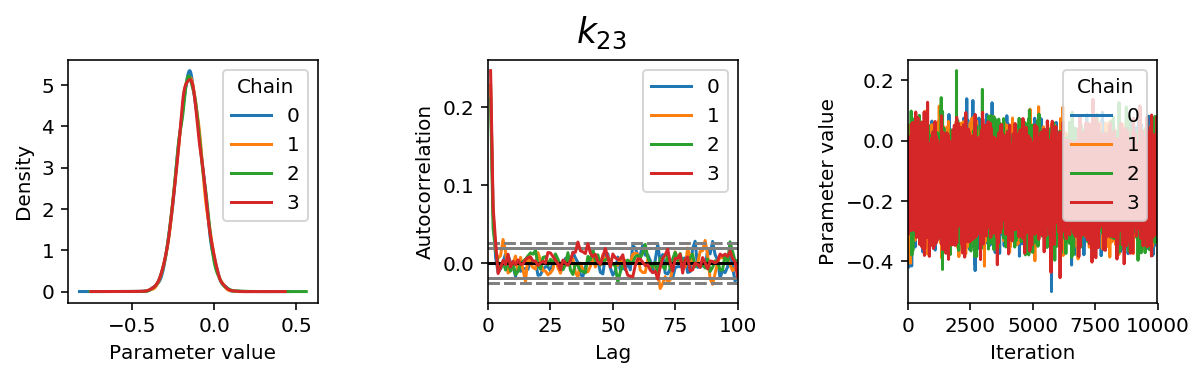

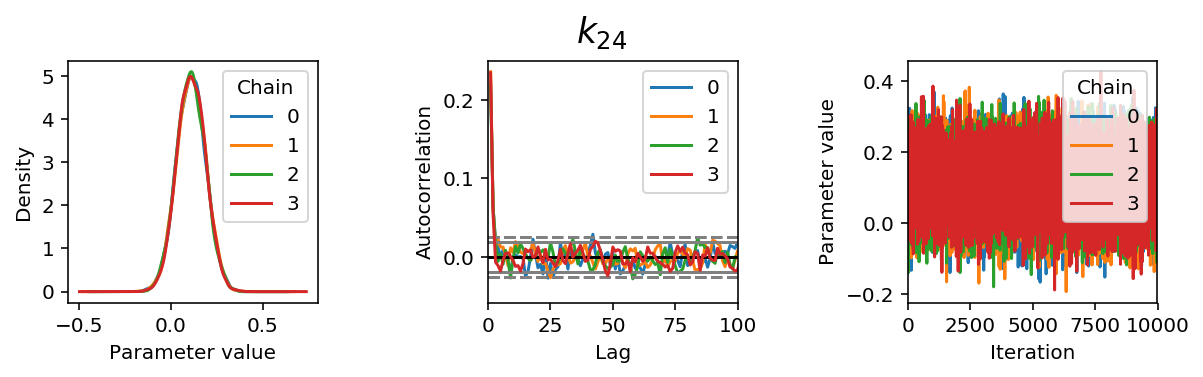

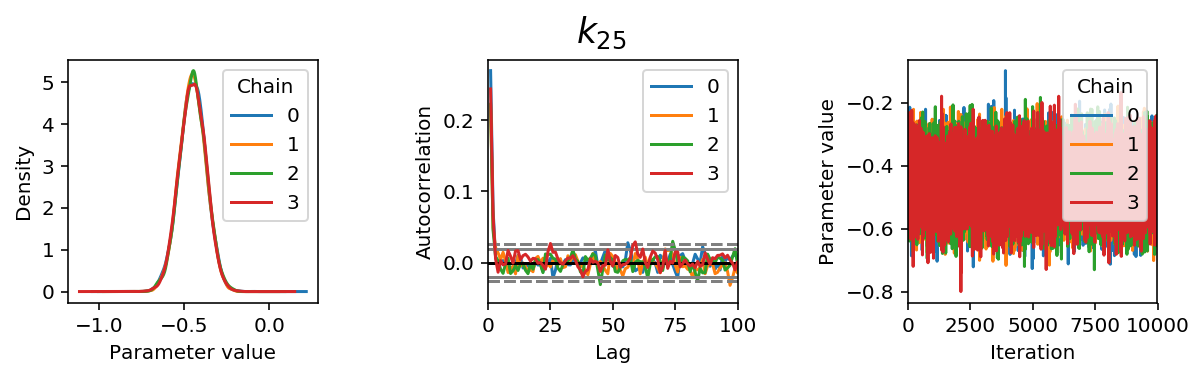

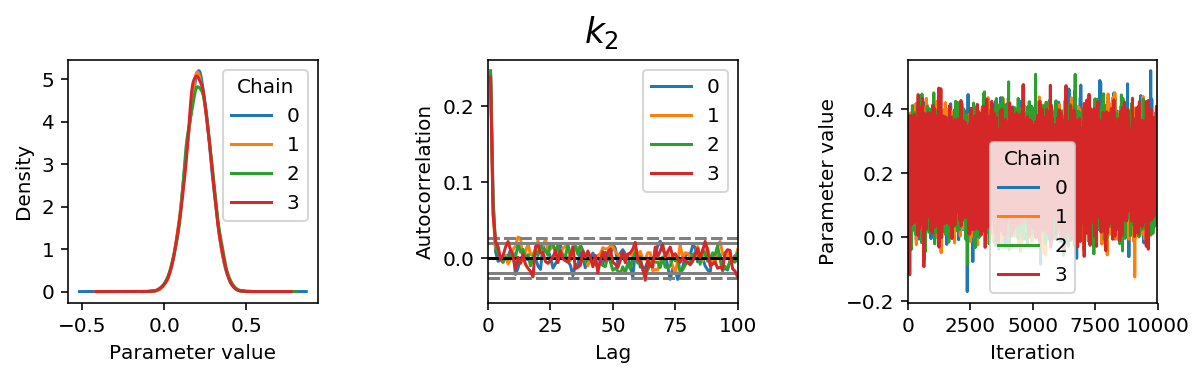

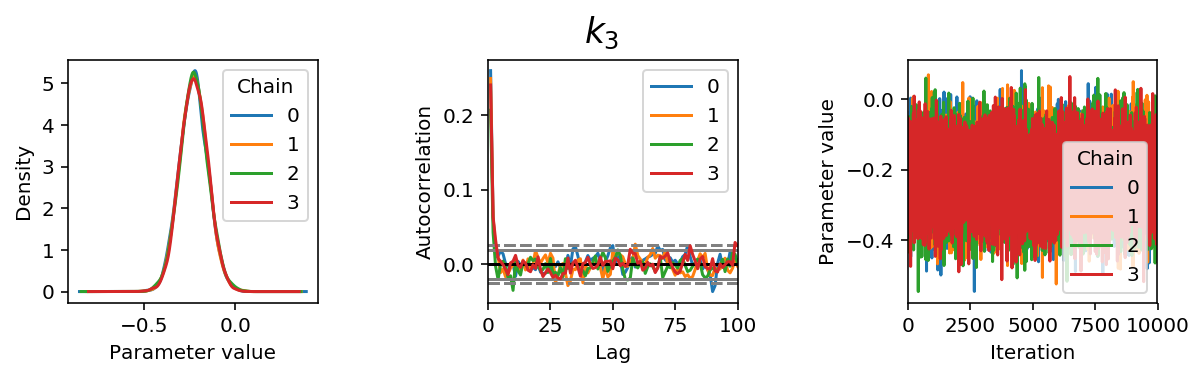

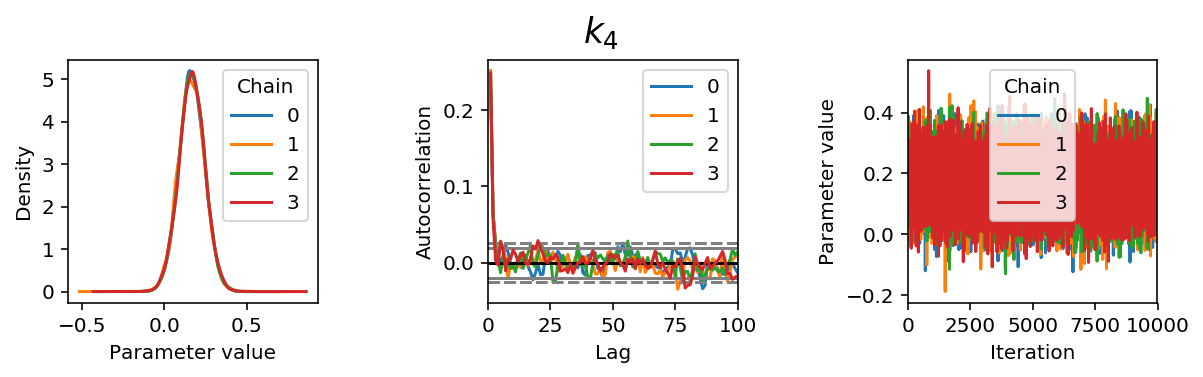

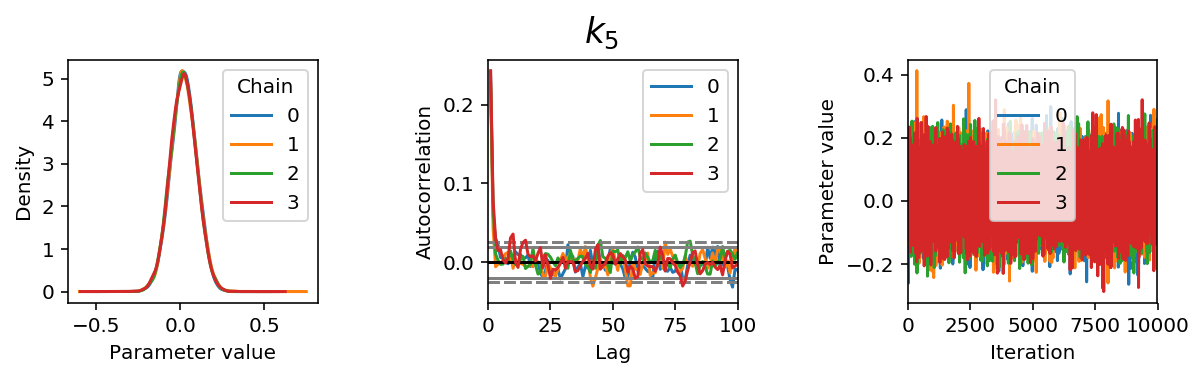

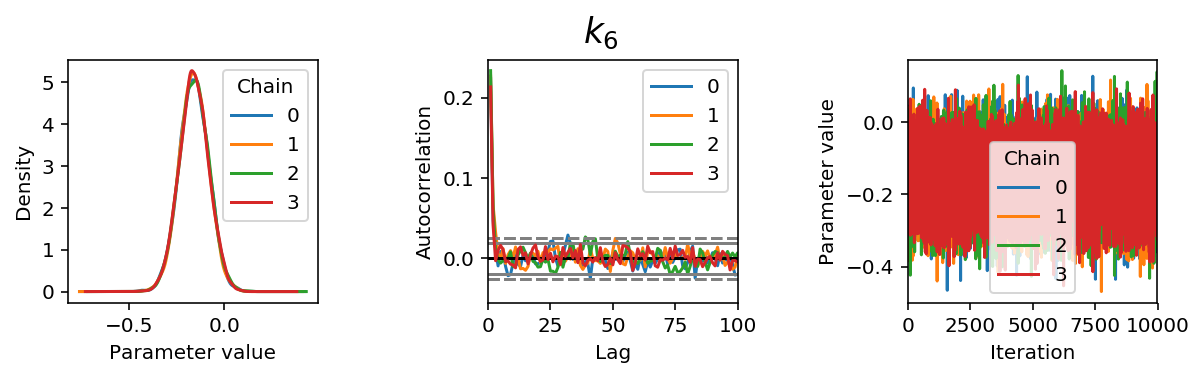

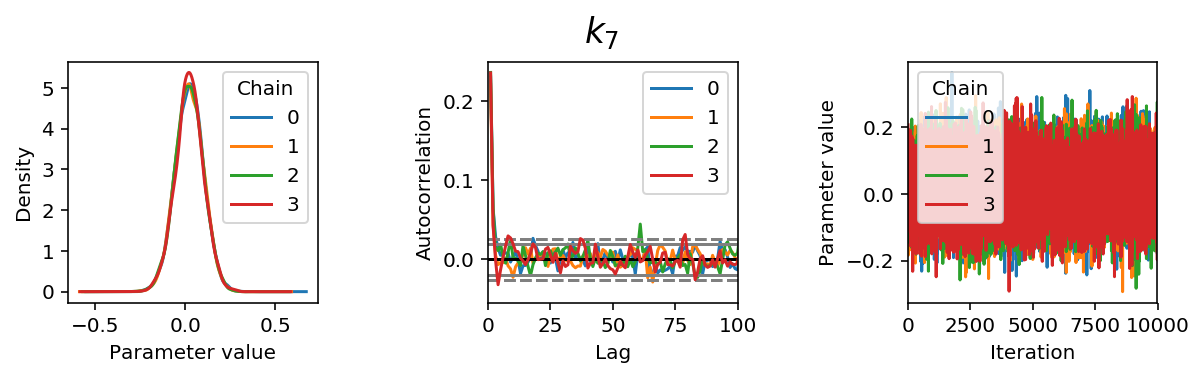

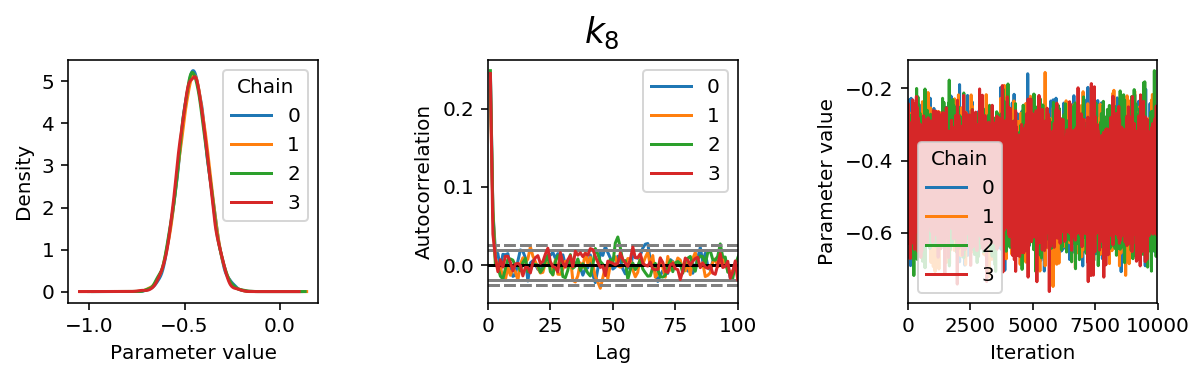

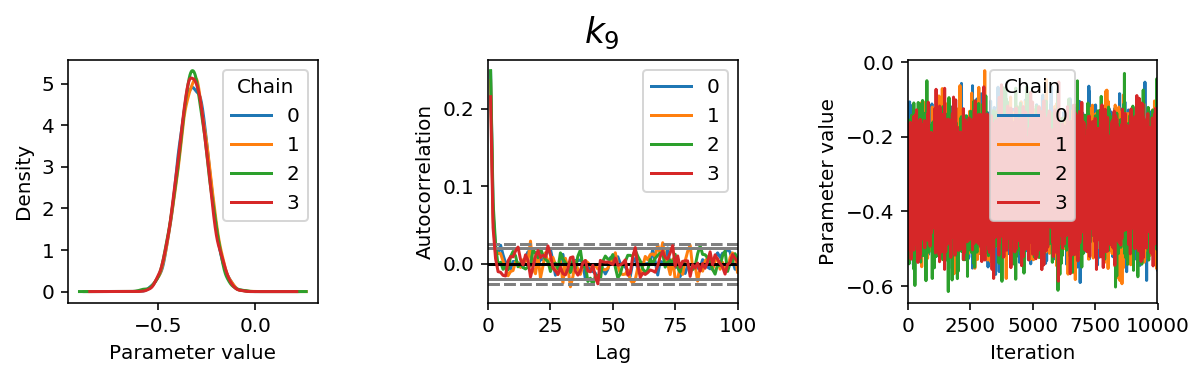

In [14]:
## Use pandas three dimensional Panel to represent the trace:

trace = pd.Panel({k: v for k, v in samples_Nm1.items()})
trace.axes[0].name = 'Variable'
trace.axes[1].name = 'Iteration'
trace.axes[2].name = 'Chain'
 
## Point estimates:
print(trace.to_frame().mean())
 
## Bayesian equal-tailed 95% credible intervals:
print(trace.to_frame().quantile([0.05, 0.95]))
  ## ^ entering the values here could be a good question part
    
def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, y=0.95, fontsize='xx-large')
 
    ## Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    ## Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    ## Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
    ## Save figure
    filename = var.replace("\\", "") 
    filename = filename.replace("$", "") 
    filename = filename.replace("}", "") 
    filename = filename.replace("{", "") 
    plt.tight_layout(pad=3)
    fig.savefig('Nm1_JAGS_h_and_k_'+'{}.png'.format(filename))
 
# Display diagnostic plots
for var in trace:
    plot(trace, var)
 


6.0
$k_{21}$
$h_{21}$
$k_{1}$
$k_{11}$
$e_{\sigma}$
$h_{1}$
$h_{11}$


/home/tunde/miniconda3/envs/dsfp_py27/lib/python2.7/site-packages/ipykernel_launcher.py:25: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.


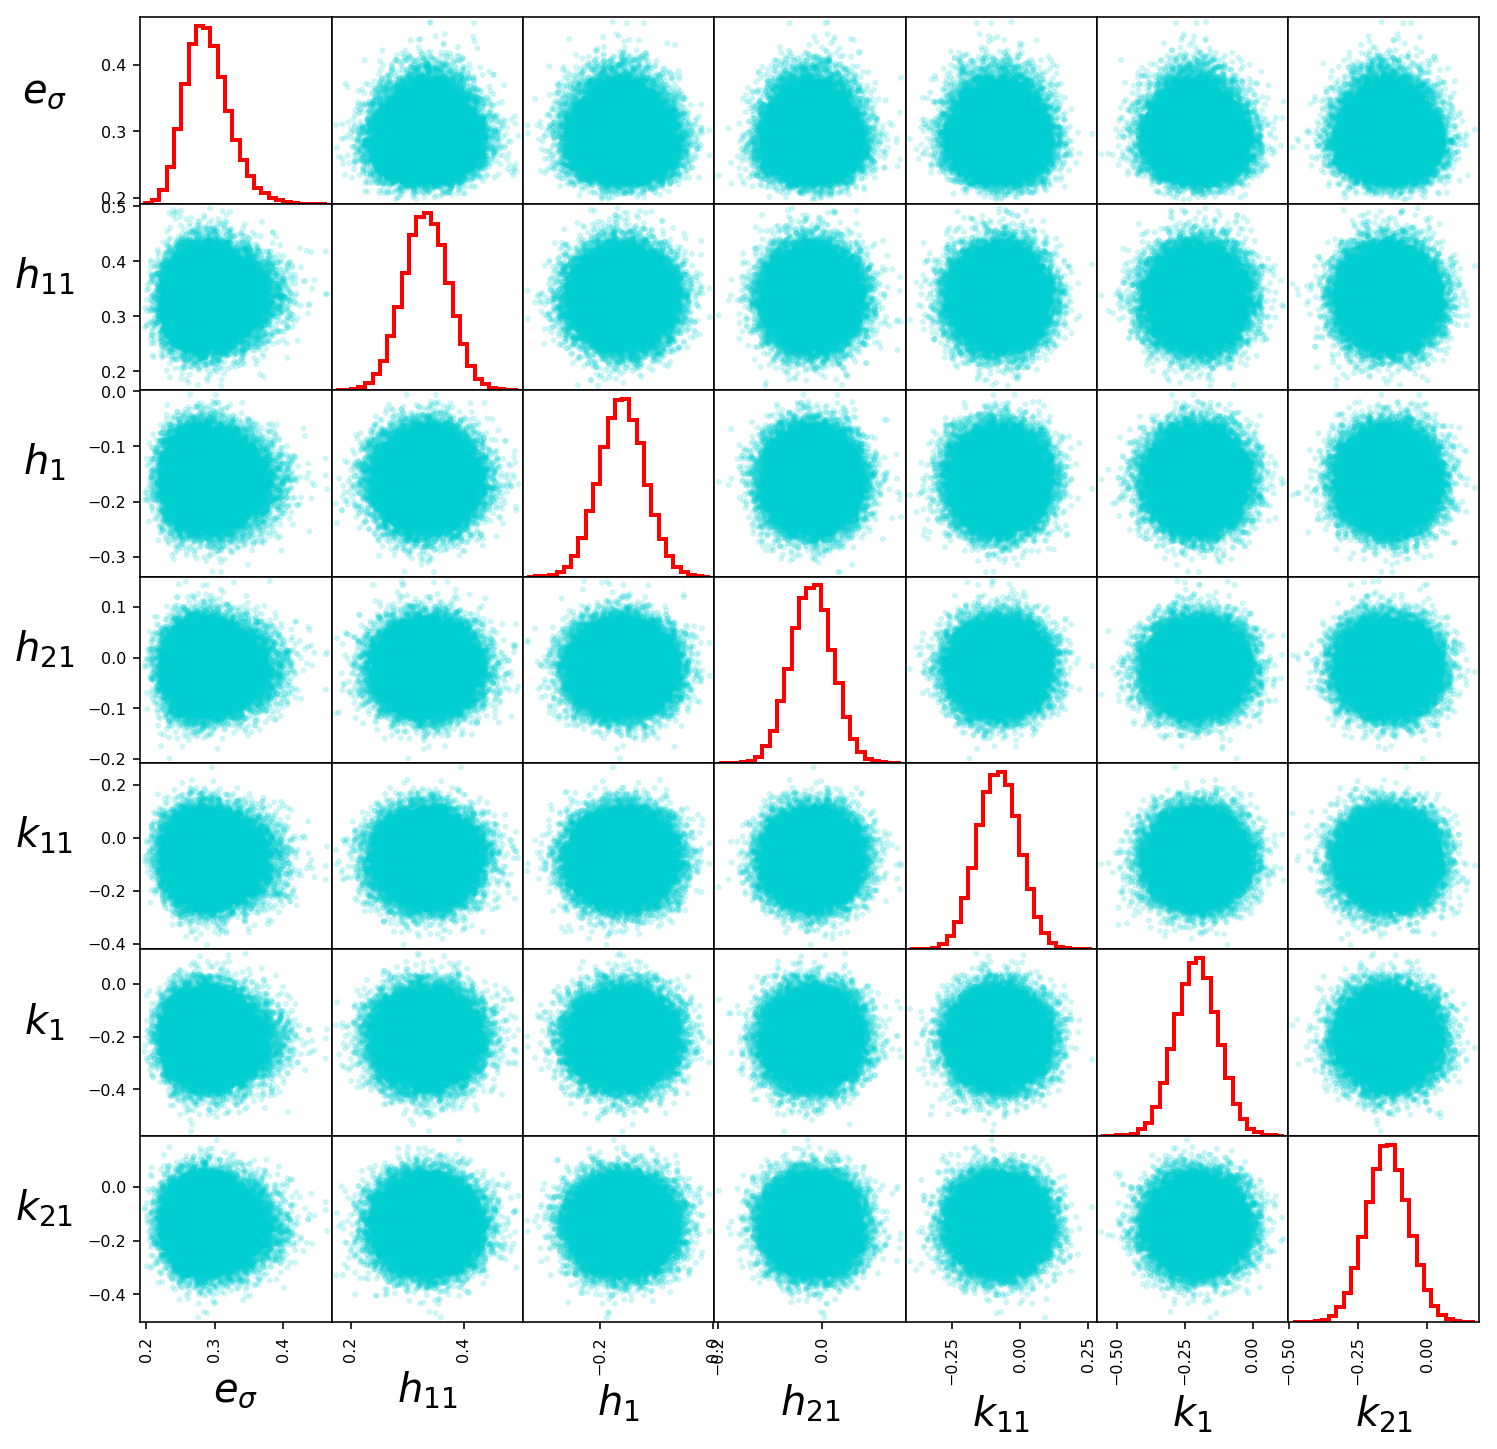

In [13]:
## Scatter matrix plot:

## Redefine the trace so that we only vizualize every 10th latent variable element in 
## the scatter_matrix plot below. Vizualizing all 50 is too cumbersome for the scatter
## matrix. 

samples_Nm1_for_scatter_matrix = {}
Nsamp=25
## adjust the thin varible to only look at every 10th population element by setting it to 10
thin = 10
numHyperParams = 1
dim = (Nsamp/thin)*2 + numHyperParams
print(dim)

for i in np.arange(0,Nsamp,thin):
    samples_Nm1_for_scatter_matrix.update({'$h_{'+str(i+1)+'}$': samples['h'][i,:,:], '$k_{'+str(i+1)+'}$': samples['k'][i,:,:]})
samples_Nm1_for_scatter_matrix.update({'$e_{\sigma}$': samples['e_sigma'].squeeze(0)})

for j, i in samples_Nm1_for_scatter_matrix.items():
    print(j)
#    print(i)

trace_2 = pd.Panel({k: v for k, v in samples_Nm1_for_scatter_matrix.items()})

sm = scatter_matrix(trace_2.to_frame(),  color="darkturquoise", alpha=0.2, figsize=(dim*2, dim*2), diagonal='hist',hist_kwds={'bins':25,'histtype':'step', 'edgecolor':'r','linewidth':2})
## y labels size
[plt.setp(item.yaxis.get_label(), 'size', 20) for item in sm.ravel()]
## x labels size 
[plt.setp(item.xaxis.get_label(), 'size', 20) for item in sm.ravel()]
## Change label rotation
## This is helpful for very long labels
#[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.xaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
## May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]
## Hide all ticks
#[s.set_xticks(()) for s in sm.reshape(-1)]
#[s.set_yticks(()) for s in sm.reshape(-1)]

plt.savefig('scatter_matrix_Nm1_JAGS.png')


<h3 align="left"> 2. Generalize to a two-component Gaussian Mixture Population Model </h3>

In [15]:
## Below we designate the population values of our two-component truncated Gaussian 
## generative model. These are the truths that we should recover if our hiararchical 
## Bayesian model is properly specified and diagnostics have indicated that the simulation 
## has "not not converged".
Ndata = 50
Nm = 2
frac = [0.7,0.3]
sigmae = [0.05,0.3]

## After generating values from the population model, we now add realistic Gaussian noise 
## to create simulated measurements. 
sigmahobs = 0.04
sigmakobs = 0.08

h = np.repeat(0.,Ndata)
k = np.repeat(0.,Ndata)
hhat = np.repeat(0.,Ndata)
khat = np.repeat(0.,Ndata)
hhat_sigma  = np.repeat(sigmahobs,Ndata)
khat_sigma  = np.repeat(sigmakobs,Ndata)

#print(khat_sigma)

for i in range(0,Ndata):
    #print('i')
    #print(i)
    
    c = np.random.choice(len(frac), 1, p=frac, replace=True)
    #print(int(c))
    h[i] = rnorm_bound(1,0,sigmae[int(c)],lower_bound=-1,upper_bound=1)
    # Euler's formula: h^2 + k^2 = 1
    lb = -np.sqrt(1-h[i]**2)
    ub = np.sqrt(1-h[i]**2)
    k[i] = rnorm_bound(1,0,sigmae[int(c)],lower_bound=lb,upper_bound=ub) 
    hhat[i] = rnorm_bound(1,h[i],sigmahobs,lower_bound=-1,upper_bound=1)
    khat[i] = rnorm_bound(1,k[i],sigmakobs,lower_bound=lb,upper_bound=ub)

    
print(h, hhat, k, khat)

[  1.89100313e-02   4.09424073e-02  -3.71081780e-02  -2.75844613e-01
   2.14055919e-04  -2.86329432e-02  -4.28138390e-02   1.79015186e-01
  -1.59605283e-01  -1.87713752e-01  -3.31479337e-02  -2.94470448e-02
  -3.20289639e-02   4.75744016e-02   3.31940187e-03   1.03026069e-01
  -6.92797246e-03   6.22716840e-01  -5.14104741e-02  -5.67877227e-02
   7.34129635e-02   8.77144659e-03  -7.37251861e-02  -1.37646241e-01
   6.65905244e-02   7.60848614e-02   7.01396171e-02  -3.57822881e-03
   1.06408228e-01   8.44058275e-02   2.95352142e-02   1.21003172e-03
   4.62475528e-01  -9.45392380e-02  -8.86351745e-03   1.70175491e-02
  -4.22873352e-02  -3.46400771e-02   2.57102205e-02  -1.96685614e-01
   3.81750305e-01   8.24883645e-02  -1.77896728e-02  -1.36237155e-01
   1.65560048e-02   4.27359800e-02  -4.85194165e-02   6.78115825e-02
   5.50355520e-01  -1.66430047e-03] [ 0.07523395  0.07287717 -0.04165737 -0.29306672  0.02589451 -0.04170534
 -0.11192604  0.16154179 -0.11473647 -0.10955842 -0.04702134 -0

In [16]:
# JAGS model code

code = '''

model {
        
    #Population parameters
    for (j in 1:Nm) {
        e_sigma[j] ~ dunif(0.0, 1.0)
        e_phi[j] <- 1/(e_sigma[j]*e_sigma[j])
        a[j] <- 1;
    }

    f ~ ddirch(a[])
        
    for (n in 1:Ndata){
    
        #True planet properties
        c[n] ~ dcat(f[]) 
        h[n] ~ dnorm(0, e_phi[c[n]]) T(-1,1) #Can try multivariate truncated normal in future
        k[n] ~ dnorm(0, e_phi[c[n]]) T(-sqrt(1-h[n]*h[n]),sqrt(1-h[n]*h[n]))
            
        #Observed planet properties
        hhat[n] ~ dnorm(h[n], 1.0/(hhat_sigma[n]*hhat_sigma[n])) T(-1,1)
        khat[n] ~ dnorm(k[n], 1.0/(khat_sigma[n]*khat_sigma[n])) T(-sqrt(1-hhat[n]*hhat[n]),sqrt(1-hhat[n]*hhat[n]))
    }
        
}
'''

In [ ]:
# Load additional JAGS module
pyjags.load_module('glm')
pyjags.load_module('dic')

#data list include only variables in the model
model = pyjags.Model(code, data=dict(Nm=Nm, Ndata=Ndata, hhat=hhat, khat=khat, 
                                     hhat_sigma=hhat_sigma, khat_sigma=khat_sigma), 
                     chains=4, adapt=1000)
# threads=4, chains_per_thread=1 
# 500 warmup / burn-in iterations, not used for inference.
model.sample(500, vars=[])

## Run model for desired steps, monitoring hyperparameter variables.
## Returns a dictionary with numpy array for each monitored variable.
## Shapes of returned arrays are (... shape of variable ..., iterations, chains).
## 
iters = 1000000
samples2 = model.sample(iters, vars=['e_sigma', 'h', 'k', 'c', 'f'])

# Pickle the data
#with open('ecc_1_test.pkl', 'wb') as handle:
#    pickle.dump(samples, handle)
    
# Retrieve pickled data
# with open('ecc_1_test.pkl', 'rb') as handle:
#      retrieved_results = pickle.load(handle)


adapting: iterations 4000 of 4000, elapsed 0:00:05, remaining 0:00:00
sampling: iterations 2000 of 2000, elapsed 0:00:02, remaining 0:00:00
sampling: iterations 7672 of 4000000, elapsed 0:00:09, remaining 1:14:21
sampling: iterations 16672 of 4000000, elapsed 0:00:18, remaining 1:12:48
sampling: iterations 25812 of 4000000, elapsed 0:00:28, remaining 1:12:04
sampling: iterations 35020 of 4000000, elapsed 0:00:38, remaining 1:11:26
sampling: iterations 44272 of 4000000, elapsed 0:00:48, remaining 1:11:08
sampling: iterations 53536 of 4000000, elapsed 0:00:58, remaining 1:10:56
sampling: iterations 62808 of 4000000, elapsed 0:01:08, remaining 1:10:41
sampling: iterations 67448 of 4000000, elapsed 0:01:13, remaining 1:10:37
sampling: iterations 72088 of 4000000, elapsed 0:01:18, remaining 1:10:40
sampling: iterations 76716 of 4000000, elapsed 0:01:23, remaining 1:10:46
sampling: iterations 81332 of 4000000, elapsed 0:01:28, remaining 1:11:03
sampling: iterations 90520 of 4000000, elapsed 

sampling: iterations 746436 of 4000000, elapsed 0:34:14, remaining 2:29:12
sampling: iterations 751888 of 4000000, elapsed 0:34:20, remaining 2:28:18
sampling: iterations 757364 of 4000000, elapsed 0:34:26, remaining 2:27:25
sampling: iterations 762864 of 4000000, elapsed 0:34:32, remaining 2:26:31
sampling: iterations 768388 of 4000000, elapsed 0:34:38, remaining 2:25:39
sampling: iterations 773936 of 4000000, elapsed 0:34:44, remaining 2:24:46
sampling: iterations 779508 of 4000000, elapsed 0:34:50, remaining 2:23:54
sampling: iterations 785104 of 4000000, elapsed 0:34:56, remaining 2:23:03
sampling: iterations 790724 of 4000000, elapsed 0:35:02, remaining 2:22:11
sampling: iterations 796368 of 4000000, elapsed 0:35:08, remaining 2:21:21
sampling: iterations 802036 of 4000000, elapsed 0:35:14, remaining 2:20:30
sampling: iterations 807728 of 4000000, elapsed 0:35:20, remaining 2:19:40
sampling: iterations 813444 of 4000000, elapsed 0:35:26, remaining 2:18:50
sampling: iterations 8191

Sort the high and low mixture components to accomidate the exchangeability of parameters

In [ ]:
chain_thin = 100
start = int(iters-1000)
esigma_low = np.where(samples2['e_sigma'][0,start::,:] <= samples2['e_sigma'][1,start::,:], samples2['e_sigma'][0,start::,:], samples2['e_sigma'][1,start::,:])
esigma_hi = np.where(samples2['e_sigma'][0,start::,:] > samples2['e_sigma'][1,start::,:], samples2['e_sigma'][0,start::,:], samples2['e_sigma'][1,start::,:])
f_low = np.where(samples2['e_sigma'][0,start::,:] <= samples2['e_sigma'][1,start::,:], samples2['f'][0,start::,:], samples2['f'][1,start::,:])
f_hi = np.where(samples2['e_sigma'][0,start::,:] > samples2['e_sigma'][1,start::,:], samples2['f'][0,start::,:], samples2['f'][1,start::,:])
print(np.min(f_hi))
plt.hist(f_low)

In [ ]:
iters = 1000000

#print(samples)
#print(samples.items())

print(samples2['h'].shape)
print(samples2['k'][0,start::,:].shape)
print('-----')
samples_Nm2 = {}
Nsamp=50
thin = 1
numHyperParams = 4
dim = (Nsamp/thin)*2 + numHyperParams
print(dim)
for i in np.arange(0,Nsamp,thin):
    samples_Nm2.update({'$h_{'+str(i+1)+'}$': samples2['h'][i,start::,:], '$k_{'+str(i+1)+'}$': samples2['k'][i,start::,:]})
samples_Nm2.update({'$e_{\sigma_{low}}$': esigma_low, '$e_{\sigma_{high}}$': esigma_hi })
samples_Nm2.update({'$f_{low}$': f_low,'$f_{high}$': f_hi })

for j, i in samples_Nm2.items():
    print(j)
    #print(i)


In [ ]:
## equal tailed 95% credible intervals, and posterior distribution means:
def summary(samples, varname, p=95):
    values = samples[varname][0]
    ci = np.percentile(values, [100-p, p])
    print('{:<6} mean = {:>5.1f}, {}% credible interval [{:>4.1f} {:>4.1f}]'.format(
      varname, np.mean(values), p, *ci))

for varname in samples_Nm2:
    summary(samples_Nm2, varname)


In [ ]:
## Use pandas three dimensional Panel to represent the trace:

trace = pd.Panel({k: v for k, v in samples_Nm2.items()})
trace.axes[0].name = 'Variable'
trace.axes[1].name = 'Iteration'
trace.axes[2].name = 'Chain'
 
## Point estimates:
print(trace.to_frame().mean())
 
## Bayesian equal-tailed 95% credible intervals:
print(trace.to_frame().quantile([0.05, 0.95]))
  ## ^ entering the values here could be a good question part
    
def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, y=0.95, fontsize='xx-large')
 
    ## Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    ## Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    ## Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
    ## Save figure
    filename = var.replace("\\", "") 
    filename = filename.replace("/", "") 
    filename = filename.replace("$", "") 
    filename = filename.replace("}", "") 
    filename = filename.replace("{", "") 
    plt.tight_layout(pad=3)
    fig.savefig('Nm2_JAGS_'+'{}.png'.format(filename))

    
## Display diagnostic plots
for var in trace:
    plot(trace, var)
 


In [ ]:
## Scatter matrix plot:

## Redefine the trace so that we only vizualize every 10th latent variable element in 
## the scatter_matrix plot below. Vizualizing all 50 is too cumbersome for the scatter
## matrix. 

samples_Nm2_for_scatter_matrix = {}

## adjust the thin varible to only look at every 10th population element by setting it to 10
thin = 10
numHyperParams = 4
dim = (Ndata/thin)*2 + numHyperParams
print(dim)

for i in np.arange(0,Ndata,thin):
    samples_Nm2_for_scatter_matrix.update({'$h_{'+str(i+1)+'}$': samples2['h'][i,start::,:], '$k_{'+str(i+1)+'}$': samples2['k'][i,start::,:]})
samples_Nm2_for_scatter_matrix.update({'$e_{\sigma_{low}}$': esigma_low, '$e_{\sigma_{high}}$': esigma_hi })
samples_Nm2_for_scatter_matrix.update({'$f_{low}$': f_low,'$f_{high}$': f_hi })

for j, i in samples_Nm2_for_scatter_matrix.items():
    print(j)
#    print(i)

trace_3 = pd.Panel({k: v for k, v in samples_Nm2_for_scatter_matrix.items()})

sm = scatter_matrix(trace_3.to_frame(),  color="darkturquoise", alpha=0.2, figsize=(dim*2, dim*2), diagonal='hist',hist_kwds={'bins':25,'histtype':'step', 'edgecolor':'r','linewidth':2})
## y labels size
[plt.setp(item.yaxis.get_label(), 'size', 20) for item in sm.ravel()]
## x labels size 
[plt.setp(item.xaxis.get_label(), 'size', 20) for item in sm.ravel()]
## Change label rotation
## This is helpful for very long labels
#[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.xaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
## May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]
## Hide all ticks
#[s.set_xticks(()) for s in sm.reshape(-1)]
#[s.set_yticks(()) for s in sm.reshape(-1)]

plt.savefig('scatter_matrix_Nm2_JAGS.png')
